# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib as mpl

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
src = "../data/zg_av_lv95.gpkg"
fiona.listlayers(src)

['cppt',
 'dprsf',
 'dprsfproj',
 'hadr',
 'lcobj',
 'lcsf',
 'lcsfproj',
 'lnna',
 'locpos',
 'mbsf',
 'osbp',
 'osnr',
 'osnrproj',
 'plli',
 'plna',
 'plsf',
 'resf',
 'resfhl',
 'resfproj',
 'slide',
 'slideobj',
 'soli',
 'soobj',
 'sopt',
 'sosf',
 'tbbp',
 'tbli']

In [4]:
zur = gpd.read_file("../data/zh_av_lv95.gpkg", layer='lcsf')

In [3]:
zug = gpd.read_file(src, layer='lcsf')
# zug.plot(figsize=(16,8))

In [4]:
minX, minY, maxX, maxY = zug.total_bounds

In [5]:
zug.crs

<Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [6]:
maxX-minX

23331.305999999866

In [7]:
maxY-minY

18445.216999999946

# Manipulation and Export

In [7]:
colMap = {'edificio':'k', 
          'altro_rivestimento_duro':'w', 
          'giardino':'dimgray', 
          'marciapiede':'w',
          'campo_prato_pascolo':'dimgray',
          'altro_humus':'dimgray',
          'vigna':'dimgray',
          'ferrovia': 'dimgray',
          'bosco_fitto': 'dimgray', 
          'bacino_idrico': 'dimgray', 
          'spartitraffico':'w', 
          'corso_acqua':'dimgray',
          'specchio_acqua':'dimgray', 
          'strada_sentiero':'w',
          'pietraia_sabbia':'dimgray',
          'torbiera': 'dimgray',
          'altra_coltura_intensiva': 'dimgray',
          'altro_bosco': 'dimgray',
          'cava_di_ghiaia_discarica': 'dimgray',
          'pascolo_boscato_fitto': 'dimgray',
          'canneti': 'dimgray',
          'roccia': 'dimgray',
          'bacino_idrico': 'dimgray',
          'specchio_acqua': 'dimgray'
         }

In [8]:
def cutAndprint(geometries, step, path):
    minX, minY, maxX, maxY = geometries.total_bounds
    repsX, repsY= int((maxX-minX)/step), int((maxY-minY)/step)
    for x in range(repsX):#range(1):
        for y in range(repsY): #range(1):
            box = gpd.GeoSeries([Polygon([(minX + (x+0) * step, minY + (y+0) * step),
                                         (minX + (x+1) * step, minY + (y+0) * step),
                                         (minX + (x+1) * step, minY + (y+1) * step),
                                         (minX + (x+0) * step, minY + (y+1) * step)])
                                      ],)
            boxGDF = gpd.GeoDataFrame.from_features(box)
            boxGDF = boxGDF.set_crs('EPSG:2056')
            res = gpd.sjoin(geometries, boxGDF, how='inner', predicate='intersects')
            res['col']= res['Genere'].map(colMap)
            nObjs = res.shape[0]
            nBld = res[res.Genere == 'edificio'].shape[0]
            
            # PLOT
            resolution = 72 # in dpi
            plt.ioff() # turns off interactive plotting
            if (nObjs > 100) and (nBld>10): # only interesting plots
                filename = path + 'CadastralX' + str(int(minX+x*step)) + 'Y' + str(int(minY+y*step)) + 'S' + str(step) + ".png" 
                #larger size, to use the crop in the dataloader
                res_multiplier = 20
                fig, ax = plt.subplots(figsize=(res_multiplier*64/resolution,res_multiplier*64/resolution), dpi=resolution, frameon=False)
                # ax = plt.axes([0,0,1,1], frameon=False)
                # ax.get_xaxis().set_visible(False)
                # ax.get_yaxis().set_visible(False)
                # plt.autoscale(tight=True)
                ax.axis('off')
                mpl.rcParams['savefig.pad_inches'] = 0
                
                ax.set_xlim(boxGDF.bounds['minx'].item(), boxGDF.bounds['maxx'].item())
                ax.set_ylim(boxGDF.bounds['miny'].item(), boxGDF.bounds['maxy'].item())
                res.plot(ax=ax, color=res['col'])
                plt.savefig(filename)
                plt.close(fig)
                # EXPORT CSV INSTEAD OF IMAGE WITH XCOORD, YCOORD, REWARD
            
            # print("Geometries in raster: {} | Box: X({}, {}), Y({}, {})".format(res.shape[0],
            #      box.total_bounds[0], box.total_bounds[2], 
            #      box.total_bounds[1], box.total_bounds[3]))

In [27]:
path = '../data/cadastralExport/'

In [33]:
%%time
cutAndprint(zug, 250, path) # +'test/')

CPU times: user 6min 47s, sys: 479 ms, total: 6min 48s
Wall time: 6min 48s


ValueError: Invalid RGBA argument: nan

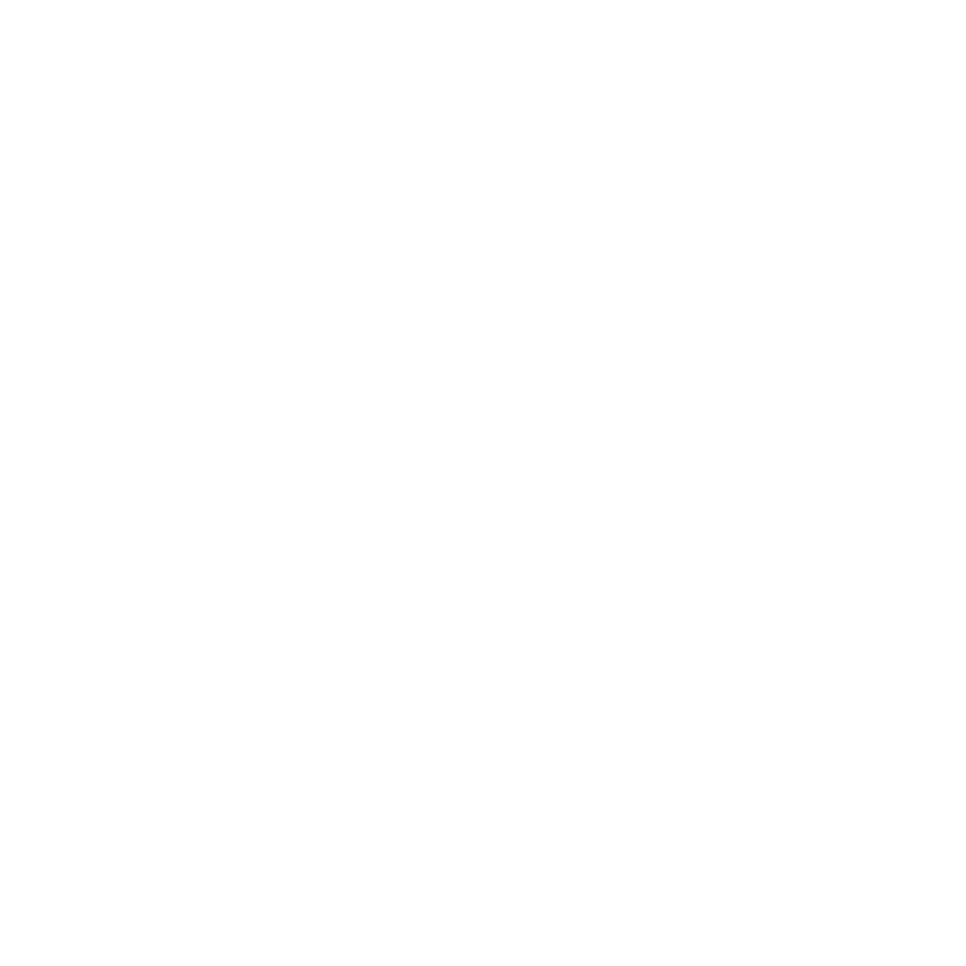

In [32]:
%%time
cutAndprint(zur, 250, path) # +'train/')

# Export as a probability to belong to a class
since the number of classes and the rgb channels are equal, each rgb color is assumed to represent the probability to belong to a class. In particular:
- [1, 0, 0] -> Red   -> Road
- [0, 1, 0] -> Green -> Green
- [0, 0 ,1] -> Blue  -> Building

In [142]:
# can = gpd.read_file("../data/av_lv95.gpkg", layer='lcsf')

In [145]:
# s = can['Genere'].unique()

In [151]:
len(s)

26

In [150]:
len(probMap)

26

In [148]:
s

array(['edificio', 'altro_rivestimento_duro', 'giardino', 'marciapiede',
       'altro_humus', 'campo_prato_pascolo', 'altro_bosco', 'torbiera',
       'altra_coltura_intensiva', 'pietraia_sabbia', 'vigna',
       'cava_di_ghiaia_discarica', 'ferrovia', 'canneti', 'roccia',
       'bosco_fitto', 'bacino_idrico', 'aeroporto', 'spartitraffico',
       'corso_acqua', 'specchio_acqua', 'strada_sentiero',
       'altra_senza_vegetazione', 'pascolo_boscato_rado',
       'pascolo_boscato_fitto', 'ghiacciaio_nevaio'], dtype=object)

In [149]:
r = (1.0, 0.0, 0.0)
g = (0.0, 1.0, 0.0)
b = (0.0, 0.0, 1.0)

probMap = {'edificio':b, 
           'altro_rivestimento_duro': r, 
           'giardino':g, 
           'marciapiede':r,
           'altro_humus': g,
           'campo_prato_pascolo':g,
           'vigna': g,
           'ferrovia': r,
           'bosco_fitto': g, 
           'bacino_idrico': g, 
           'spartitraffico': r, 
           'corso_acqua':g,
           'specchio_acqua':g, 
           'strada_sentiero':r,
           'pietraia_sabbia':g,
           'torbiera': g,
           'altra_coltura_intensiva': g,
           'altro_bosco': g,
           'cava_di_ghiaia_discarica': g,
           'pascolo_boscato_fitto': g,
           'canneti': g,
           'roccia': g,
           'bacino_idrico': g,
           'specchio_acqua': g,
           'ghiacciaio_nevaio': g,
           'pascolo_boscato_rado': g,
           'altra_senza_vegetazione': g,
           'aeroporto': r
          }

# probMap = {'edificio':'b', 
#            'altro_rivestimento_duro':'r', 
#            'giardino':'g', 
#            'marciapiede':'r',
#            'campo_prato_pascolo':'g',
#            'altro_humus':'g',
#            'vigna':'g',
#            'ferrovia': 'r' ## PREVIOUSLY 'g',
#            'bosco_fitto': 'g', 
#            'bacino_idrico': 'g', 
#            'spartitraffico':'r', 
#            'corso_acqua':'g',
#            'specchio_acqua':'g', 
#            'strada_sentiero':'r',
#            'pietraia_sabbia':'g',
#            'torbiera': 'g',
#            'altra_coltura_intensiva': 'g',
#            'altro_bosco': 'g',
#            'cava_di_ghiaia_discarica': 'g',
#            'pascolo_boscato_fitto': 'g',
#            'canneti': 'g',
#            'roccia': 'g',
#            'bacino_idrico': 'g',
#            'specchio_acqua': 'g'
#           }

In [9]:
probMap

{'edificio': (0.0, 0.0, 1.0),
 'altro_rivestimento_duro': (1.0, 0.0, 0.0),
 'giardino': (0.0, 1.0, 0.0),
 'marciapiede': (1.0, 0.0, 0.0),
 'campo_prato_pascolo': (0.0, 1.0, 0.0),
 'altro_humus': (0.0, 1.0, 0.0),
 'vigna': (0.0, 1.0, 0.0),
 'ferrovia': (1.0, 0.0, 0.0),
 'bosco_fitto': (0.0, 1.0, 0.0),
 'bacino_idrico': (0.0, 1.0, 0.0),
 'spartitraffico': (1.0, 0.0, 0.0),
 'corso_acqua': (0.0, 1.0, 0.0),
 'specchio_acqua': (0.0, 1.0, 0.0),
 'strada_sentiero': (1.0, 0.0, 0.0),
 'pietraia_sabbia': (0.0, 1.0, 0.0),
 'torbiera': (0.0, 1.0, 0.0),
 'altra_coltura_intensiva': (0.0, 1.0, 0.0),
 'altro_bosco': (0.0, 1.0, 0.0),
 'cava_di_ghiaia_discarica': (0.0, 1.0, 0.0),
 'pascolo_boscato_fitto': (0.0, 1.0, 0.0),
 'canneti': (0.0, 1.0, 0.0),
 'roccia': (0.0, 1.0, 0.0)}

In [10]:
def cut_and_print_probs(geometries, step, path):
    tree = STRtree(geometries)
    minX, minY, maxX, maxY = geometries.total_bounds
    repsX, repsY= int((maxX-minX)/step), int((maxY-minY)/step)
    for x in range(repsX):#range(1):
        for y in range(repsY): #range(1):
            box = gpd.GeoSeries([Polygon([(minX + (x+0) * step, minY + (y+0) * step),
                                         (minX + (x+1) * step, minY + (y+0) * step),
                                         (minX + (x+1) * step, minY + (y+1) * step),
                                         (minX + (x+0) * step, minY + (y+1) * step)])
                                      ],)
            boxGDF = gpd.GeoDataFrame.from_features(box)
            boxGDF = boxGDF.set_crs('EPSG:2056')
            res = gpd.sjoin(geometries, boxGDF, how='inner', predicate='intersects')
            res['col']= res['Genere'].map(probMap)
            nObjs = res.shape[0]
            nBld = res[res.Genere == 'edificio'].shape[0]
            
            # PLOT
            resolution = 72 # in dpi
            plt.ioff() # turns off interactive plotting
            if (nObjs > 100) and (nBld>10): # only interesting plots
                filename = path + 'CadastralX' + str(int(minX+x*step)) + 'Y' + str(int(minY+y*step)) + 'S' + str(step) + ".png" 
                #larger size, to use the crop in the dataloader
                res_multiplier = 20
                fig, ax = plt.subplots(figsize=(res_multiplier*64/resolution,res_multiplier*64/resolution), dpi=resolution, frameon=False)
                # ax = plt.axes([0,0,1,1], frameon=False)
                # ax.get_xaxis().set_visible(False)
                # ax.get_yaxis().set_visible(False)
                # plt.autoscale(tight=True)
                ax.axis('off')
                mpl.rcParams['savefig.pad_inches'] = 0
                
                ax.set_xlim(boxGDF.bounds['minx'].item(), boxGDF.bounds['maxx'].item())
                ax.set_ylim(boxGDF.bounds['miny'].item(), boxGDF.bounds['maxy'].item())
                res.plot(ax=ax, color=res['col'])
                plt.savefig(filename)
                plt.close(fig)
                # EXPORT CSV INSTEAD OF IMAGE WITH XCOORD, YCOORD, REWARD
            
            # print("Geometries in raster: {} | Box: X({}, {}), Y({}, {})".format(res.shape[0],
            #      box.total_bounds[0], box.total_bounds[2], 
            #      box.total_bounds[1], box.total_bounds[3]))

In [63]:
step = 250
tree = zug.sindex
minX, minY, maxX, maxY = zug.total_bounds
repsX, repsY= int((maxX-minX)/step), int((maxY-minY)/step)

In [64]:
x, y = random.randrange(0, repsX), random.randrange(0, repsY)
print(f'x: {x}, y: {y}')
box = gpd.GeoSeries([Polygon([(minX + (x+0) * step, minY + (y+0) * step),
                              (minX + (x+1) * step, minY + (y+0) * step),
                              (minX + (x+1) * step, minY + (y+1) * step),
                              (minX + (x+0) * step, minY + (y+1) * step)])
                                      ],)
boxGDF = gpd.GeoDataFrame.from_features(box)
boxGDF = boxGDF.set_crs('EPSG:2056')
            

x: 64, y: 32


In [110]:
# select with STRtree
selection = list(tree.query(boxGDF.geometry)[1])
selected = zug.iloc[selection]

In [109]:
selected

,NumeroUFS,Qualita,Genere,REA_EGID,Cantone,geometry
41795,1704,MU93,campo_prato_pascolo,NaN,ZG,"POLYGON ((2688379.208 1223225.523, 2688381.132..."
39305,1704,MU93,torbiera,NaN,ZG,"POLYGON ((2688371.564 1223212.217, 2688374.653..."
37736,1704,MU93,edificio,314824,ZG,"POLYGON ((2688483.651 1223258.021, 2688484.025..."
38162,1704,MU93,giardino,NaN,ZG,"POLYGON ((2688469.310 1223276.646, 2688489.291..."
37796,1704,MU93,edificio,502189704,ZG,"POLYGON ((2688473.718 1223266.132, 2688473.870..."
39294,1704,MU93,torbiera,NaN,ZG,"POLYGON ((2688355.489 1223332.094, 2688374.341..."
66648,1706,MU93,bosco_fitto,NaN,ZG,"POLYGON ((2688495.985 1222646.560, 2688496.074..."
67056,1706,MU93,bosco_fitto,NaN,ZG,"POLYGON ((2688313.986 1222854.340, 2688315.410..."
74230,1706,MU93,strada_sentiero,NaN,ZG,"POLYGON ((2688311.776 1222854.357, 2688313.229..."
66617,1706,MU93,bosco_fitto,NaN,ZG,"POLYGON ((2688134.832 1222945.481, 2688139.713..."


In [99]:
selected = selected.reset_index()
selected

,index,NumeroUFS,Qualita,Genere,REA_EGID,Cantone,geometry
0,41795,1704,MU93,campo_prato_pascolo,NaN,ZG,"POLYGON ((2688379.208 1223225.523, 2688381.132..."
1,39305,1704,MU93,torbiera,NaN,ZG,"POLYGON ((2688371.564 1223212.217, 2688374.653..."
2,37736,1704,MU93,edificio,314824,ZG,"POLYGON ((2688483.651 1223258.021, 2688484.025..."
3,38162,1704,MU93,giardino,NaN,ZG,"POLYGON ((2688469.310 1223276.646, 2688489.291..."
4,37796,1704,MU93,edificio,502189704,ZG,"POLYGON ((2688473.718 1223266.132, 2688473.870..."
5,39294,1704,MU93,torbiera,NaN,ZG,"POLYGON ((2688355.489 1223332.094, 2688374.341..."
6,66648,1706,MU93,bosco_fitto,NaN,ZG,"POLYGON ((2688495.985 1222646.560, 2688496.074..."
7,67056,1706,MU93,bosco_fitto,NaN,ZG,"POLYGON ((2688313.986 1222854.340, 2688315.410..."
8,74230,1706,MU93,strada_sentiero,NaN,ZG,"POLYGON ((2688311.776 1222854.357, 2688313.229..."
9,66617,1706,MU93,bosco_fitto,NaN,ZG,"POLYGON ((2688134.832 1222945.481, 2688139.713..."


In [101]:
selected.intersects(boxGDF.geometry)

/home/furio/.local/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0      True
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
dtype: bool

In [104]:
res = selected[selected.intersects(boxGDF.geometry)]

/home/furio/.local/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [105]:
res

,index,NumeroUFS,Qualita,Genere,REA_EGID,Cantone,geometry
0,41795,1704,MU93,campo_prato_pascolo,NaN,ZG,"POLYGON ((2688379.208 1223225.523, 2688381.132..."


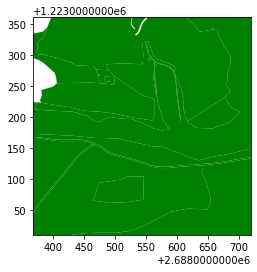

In [115]:
f, ax = plt.subplots()
# thesmallpoints.plot(ax=ax, marker='o', color='blue', markersize=20)
#thelargeline.plot(ax=ax, color='green')
selected.plot(ax = ax, color = 'green')
# boxGDF.plot(ax = ax, alpha = 0.9)
# res.plot(ax=ax, color = 'red')
ax.set_xlim(minX + x * step- 50, minX + (x+1) * step + 50) # added/substracted value is to give some margin around total bounds
ax.set_ylim(minY + y * step- 50, minY + (y+1) * step + 50)
plt.show()

In [119]:
selected['col']= selected['Genere'].map(probMap)

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [139]:
type(selected['col'].iloc[1])

tuple

In [138]:
selected.shape[0]

21

In [141]:
def cut_and_print_probs(geometries, step, path):
    # Construct the STRtree object
    tree = geometries.sindex
    
    minX, minY, maxX, maxY = geometries.total_bounds
    repsX, repsY= int((maxX-minX)/step), int((maxY-minY)/step)
    counter = 0
    for x in range(repsX):#range(1):
        for y in range(repsY): #range(1):
            print(f'Progress: {y + x * repsY} / {repsX*repsY}')
            box = gpd.GeoSeries([Polygon([(minX + (x+0) * step, minY + (y+0) * step),
                                         (minX + (x+1) * step, minY + (y+0) * step),
                                         (minX + (x+1) * step, minY + (y+1) * step),
                                         (minX + (x+0) * step, minY + (y+1) * step)])
                                      ],)
            boxGDF = gpd.GeoDataFrame.from_features(box)
            boxGDF = boxGDF.set_crs('EPSG:2056')
            # select with STRtree
            selection = list(tree.query(boxGDF.geometry)[1])
            res = geometries.iloc[selection]
            # Filter for intersecting triangle
            # res = [g for g in res if g.intersects(boxGDF.geometry)]
            # AVOIDING SPATIAL JOIN
            # res = gpd.sjoin(geometries, boxGDF, how='inner', predicate='intersects')
            nObjs = res.shape[0]
            nBld = res[res.Genere == 'edificio'].shape[0]
            # PLOT
            resolution = 72 # in dpi
            plt.ioff() # turns off interactive plotting
            if (nObjs > 100) and (nBld>10): # only interesting plots
                res['col']= res['Genere'].map(probMap)
                filename = path + 'CadastralX' + str(int(minX+x*step)) + 'Y' + str(int(minY+y*step)) + 'S' + str(step) + ".png" 
                #larger size, to use the crop in the dataloader
                res_multiplier = 20
                fig, ax = plt.subplots(figsize=(res_multiplier*64/resolution,res_multiplier*64/resolution), dpi=resolution, frameon=False)
                # ax = plt.axes([0,0,1,1], frameon=False)
                # ax.get_xaxis().set_visible(False)
                # ax.get_yaxis().set_visible(False)
                # plt.autoscale(tight=True)
                ax.axis('off')
                mpl.rcParams['savefig.pad_inches'] = 0
                
                ax.set_xlim(boxGDF.bounds['minx'].item(), boxGDF.bounds['maxx'].item())
                ax.set_ylim(boxGDF.bounds['miny'].item(), boxGDF.bounds['maxy'].item())
                res.plot(ax=ax, color=res['col'])
                plt.savefig(filename)
                plt.close(fig)
                print (f'---> saved file nr {counter} with name {filename} in step {y + x * repsY} / {repsX*repsY}')
                counter += 1

    return

pathRGB = '../../cadastralExportRGB/train/'

cut_and_print_probs(zug, 250, pathRGB)

Progress: 0 / 6789
Progress: 1 / 6789
Progress: 2 / 6789
Progress: 3 / 6789
Progress: 4 / 6789
Progress: 5 / 6789
Progress: 6 / 6789
Progress: 7 / 6789
Progress: 8 / 6789
Progress: 9 / 6789
Progress: 10 / 6789
Progress: 11 / 6789
Progress: 12 / 6789
Progress: 13 / 6789
Progress: 14 / 6789
Progress: 15 / 6789
Progress: 16 / 6789
Progress: 17 / 6789
Progress: 18 / 6789
Progress: 19 / 6789
Progress: 20 / 6789
Progress: 21 / 6789
Progress: 22 / 6789
Progress: 23 / 6789
Progress: 24 / 6789
Progress: 25 / 6789
Progress: 26 / 6789
Progress: 27 / 6789
Progress: 28 / 6789
Progress: 29 / 6789
Progress: 30 / 6789
Progress: 31 / 6789
Progress: 32 / 6789
Progress: 33 / 6789
Progress: 34 / 6789
Progress: 35 / 6789
Progress: 36 / 6789
Progress: 37 / 6789
Progress: 38 / 6789
Progress: 39 / 6789
Progress: 40 / 6789
Progress: 41 / 6789
Progress: 42 / 6789
Progress: 43 / 6789
Progress: 44 / 6789
Progress: 45 / 6789
Progress: 46 / 6789
Progress: 47 / 6789
Progress: 48 / 6789
Progress: 49 / 6789
Progress: 

Progress: 403 / 6789
Progress: 404 / 6789
Progress: 405 / 6789
Progress: 406 / 6789
Progress: 407 / 6789
Progress: 408 / 6789
Progress: 409 / 6789
Progress: 410 / 6789
Progress: 411 / 6789
Progress: 412 / 6789
Progress: 413 / 6789
Progress: 414 / 6789
Progress: 415 / 6789
Progress: 416 / 6789
Progress: 417 / 6789
Progress: 418 / 6789
Progress: 419 / 6789
Progress: 420 / 6789
Progress: 421 / 6789
Progress: 422 / 6789
Progress: 423 / 6789
Progress: 424 / 6789
Progress: 425 / 6789
Progress: 426 / 6789
Progress: 427 / 6789
Progress: 428 / 6789
Progress: 429 / 6789
Progress: 430 / 6789
Progress: 431 / 6789
Progress: 432 / 6789
Progress: 433 / 6789
Progress: 434 / 6789
Progress: 435 / 6789
Progress: 436 / 6789
Progress: 437 / 6789
Progress: 438 / 6789
Progress: 439 / 6789
Progress: 440 / 6789
Progress: 441 / 6789
Progress: 442 / 6789
Progress: 443 / 6789
Progress: 444 / 6789
Progress: 445 / 6789
Progress: 446 / 6789
Progress: 447 / 6789
Progress: 448 / 6789
Progress: 449 / 6789
Progress: 450

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 0 with name ../../cadastralExportRGB/train/CadastralX2674418Y1225310S250.png in step 625 / 6789
Progress: 626 / 6789
---> saved file nr 1 with name ../../cadastralExportRGB/train/CadastralX2674418Y1225560S250.png in step 626 / 6789
Progress: 627 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 2 with name ../../cadastralExportRGB/train/CadastralX2674418Y1225810S250.png in step 627 / 6789
Progress: 628 / 6789
Progress: 629 / 6789
Progress: 630 / 6789
Progress: 631 / 6789
Progress: 632 / 6789
Progress: 633 / 6789
Progress: 634 / 6789
Progress: 635 / 6789
Progress: 636 / 6789
Progress: 637 / 6789
Progress: 638 / 6789
Progress: 639 / 6789
Progress: 640 / 6789
Progress: 641 / 6789
Progress: 642 / 6789
Progress: 643 / 6789
Progress: 644 / 6789
Progress: 645 / 6789
Progress: 646 / 6789
Progress: 647 / 6789
Progress: 648 / 6789
Progress: 649 / 6789
Progress: 650 / 6789
Progress: 651 / 6789
Progress: 652 / 6789
Progress: 653 / 6789
Progress: 654 / 6789
Progress: 655 / 6789
Progress: 656 / 6789
Progress: 657 / 6789
Progress: 658 / 6789
Progress: 659 / 6789
Progress: 660 / 6789
Progress: 661 / 6789
Progress: 662 / 6789
Progress: 663 / 6789
Progress: 664 / 6789
Progress: 665 / 6789
Progress: 666 / 6789
Progress: 667 / 6789
Progress: 668 / 6789
Progress: 669 / 6789
Pro

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 3 with name ../../cadastralExportRGB/train/CadastralX2674668Y1220810S250.png in step 680 / 6789
Progress: 681 / 6789
Progress: 682 / 6789
---> saved file nr 4 with name ../../cadastralExportRGB/train/CadastralX2674668Y1221310S250.png in step 682 / 6789
Progress: 683 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 5 with name ../../cadastralExportRGB/train/CadastralX2674668Y1221560S250.png in step 683 / 6789
Progress: 684 / 6789
---> saved file nr 6 with name ../../cadastralExportRGB/train/CadastralX2674668Y1221810S250.png in step 684 / 6789
Progress: 685 / 6789
Progress: 686 / 6789
Progress: 687 / 6789
Progress: 688 / 6789
Progress: 689 / 6789
Progress: 690 / 6789
Progress: 691 / 6789
Progress: 692 / 6789
Progress: 693 / 6789
Progress: 694 / 6789
Progress: 695 / 6789
Progress: 696 / 6789
---> saved file nr 7 with name ../../cadastralExportRGB/train/CadastralX2674668Y1224810S250.png in step 696 / 6789
Progress: 697 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 8 with name ../../cadastralExportRGB/train/CadastralX2674668Y1225060S250.png in step 697 / 6789
Progress: 698 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 9 with name ../../cadastralExportRGB/train/CadastralX2674668Y1225310S250.png in step 698 / 6789
Progress: 699 / 6789
---> saved file nr 10 with name ../../cadastralExportRGB/train/CadastralX2674668Y1225560S250.png in step 699 / 6789
Progress: 700 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 11 with name ../../cadastralExportRGB/train/CadastralX2674668Y1225810S250.png in step 700 / 6789
Progress: 701 / 6789
Progress: 702 / 6789
Progress: 703 / 6789
Progress: 704 / 6789
Progress: 705 / 6789
Progress: 706 / 6789
Progress: 707 / 6789
Progress: 708 / 6789
Progress: 709 / 6789
Progress: 710 / 6789
Progress: 711 / 6789
Progress: 712 / 6789
Progress: 713 / 6789
Progress: 714 / 6789
Progress: 715 / 6789
Progress: 716 / 6789
Progress: 717 / 6789
Progress: 718 / 6789
Progress: 719 / 6789
Progress: 720 / 6789
Progress: 721 / 6789
Progress: 722 / 6789
Progress: 723 / 6789
Progress: 724 / 6789
Progress: 725 / 6789
Progress: 726 / 6789
Progress: 727 / 6789
Progress: 728 / 6789
Progress: 729 / 6789
Progress: 730 / 6789
Progress: 731 / 6789
Progress: 732 / 6789
Progress: 733 / 6789
Progress: 734 / 6789
Progress: 735 / 6789
Progress: 736 / 6789
Progress: 737 / 6789
Progress: 738 / 6789
Progress: 739 / 6789
Progress: 740 / 6789
Progress: 741 / 6789
Progress: 742 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 12 with name ../../cadastralExportRGB/train/CadastralX2674918Y1220810S250.png in step 753 / 6789
Progress: 754 / 6789
---> saved file nr 13 with name ../../cadastralExportRGB/train/CadastralX2674918Y1221060S250.png in step 754 / 6789
Progress: 755 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 14 with name ../../cadastralExportRGB/train/CadastralX2674918Y1221310S250.png in step 755 / 6789
Progress: 756 / 6789
---> saved file nr 15 with name ../../cadastralExportRGB/train/CadastralX2674918Y1221560S250.png in step 756 / 6789
Progress: 757 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 16 with name ../../cadastralExportRGB/train/CadastralX2674918Y1221810S250.png in step 757 / 6789
Progress: 758 / 6789
---> saved file nr 17 with name ../../cadastralExportRGB/train/CadastralX2674918Y1222060S250.png in step 758 / 6789
Progress: 759 / 6789
Progress: 760 / 6789
Progress: 761 / 6789
Progress: 762 / 6789
Progress: 763 / 6789
Progress: 764 / 6789
Progress: 765 / 6789
Progress: 766 / 6789
Progress: 767 / 6789
Progress: 768 / 6789
Progress: 769 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 18 with name ../../cadastralExportRGB/train/CadastralX2674918Y1224810S250.png in step 769 / 6789
Progress: 770 / 6789
---> saved file nr 19 with name ../../cadastralExportRGB/train/CadastralX2674918Y1225060S250.png in step 770 / 6789
Progress: 771 / 6789
Progress: 772 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 20 with name ../../cadastralExportRGB/train/CadastralX2674918Y1225560S250.png in step 772 / 6789
Progress: 773 / 6789
---> saved file nr 21 with name ../../cadastralExportRGB/train/CadastralX2674918Y1225810S250.png in step 773 / 6789
Progress: 774 / 6789
Progress: 775 / 6789
Progress: 776 / 6789
Progress: 777 / 6789
Progress: 778 / 6789
Progress: 779 / 6789
Progress: 780 / 6789
Progress: 781 / 6789
Progress: 782 / 6789
Progress: 783 / 6789
Progress: 784 / 6789
Progress: 785 / 6789
Progress: 786 / 6789
Progress: 787 / 6789
Progress: 788 / 6789
Progress: 789 / 6789
Progress: 790 / 6789
Progress: 791 / 6789
Progress: 792 / 6789
Progress: 793 / 6789
Progress: 794 / 6789
Progress: 795 / 6789
Progress: 796 / 6789
Progress: 797 / 6789
Progress: 798 / 6789
Progress: 799 / 6789
Progress: 800 / 6789
Progress: 801 / 6789
Progress: 802 / 6789
Progress: 803 / 6789
Progress: 804 / 6789
Progress: 805 / 6789
Progress: 806 / 6789
Progress: 807 / 6789
Progress: 808 / 6789
Progress: 80

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 22 with name ../../cadastralExportRGB/train/CadastralX2675168Y1221060S250.png in step 827 / 6789
Progress: 828 / 6789
---> saved file nr 23 with name ../../cadastralExportRGB/train/CadastralX2675168Y1221310S250.png in step 828 / 6789
Progress: 829 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 24 with name ../../cadastralExportRGB/train/CadastralX2675168Y1221560S250.png in step 829 / 6789
Progress: 830 / 6789
---> saved file nr 25 with name ../../cadastralExportRGB/train/CadastralX2675168Y1221810S250.png in step 830 / 6789
Progress: 831 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 26 with name ../../cadastralExportRGB/train/CadastralX2675168Y1222060S250.png in step 831 / 6789
Progress: 832 / 6789
---> saved file nr 27 with name ../../cadastralExportRGB/train/CadastralX2675168Y1222310S250.png in step 832 / 6789
Progress: 833 / 6789
Progress: 834 / 6789
Progress: 835 / 6789
Progress: 836 / 6789
Progress: 837 / 6789
Progress: 838 / 6789
Progress: 839 / 6789
Progress: 840 / 6789
Progress: 841 / 6789
Progress: 842 / 6789
Progress: 843 / 6789
Progress: 844 / 6789
Progress: 845 / 6789
---> saved file nr 28 with name ../../cadastralExportRGB/train/CadastralX2675168Y1225560S250.png in step 845 / 6789
Progress: 846 / 6789
Progress: 847 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 848 / 6789
Progress: 849 / 6789
Progress: 850 / 6789
Progress: 851 / 6789
Progress: 852 / 6789
Progress: 853 / 6789
Progress: 854 / 6789
Progress: 855 / 6789
---> saved file nr 29 with name ../../cadastralExportRGB/train/CadastralX2675168Y1228060S250.png in step 855 / 6789
Progress: 856 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 30 with name ../../cadastralExportRGB/train/CadastralX2675168Y1228310S250.png in step 856 / 6789
Progress: 857 / 6789
---> saved file nr 31 with name ../../cadastralExportRGB/train/CadastralX2675168Y1228560S250.png in step 857 / 6789
Progress: 858 / 6789
Progress: 859 / 6789
Progress: 860 / 6789
Progress: 861 / 6789
Progress: 862 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 863 / 6789
Progress: 864 / 6789
Progress: 865 / 6789
Progress: 866 / 6789
Progress: 867 / 6789
Progress: 868 / 6789
Progress: 869 / 6789
Progress: 870 / 6789
Progress: 871 / 6789
Progress: 872 / 6789
Progress: 873 / 6789
Progress: 874 / 6789
Progress: 875 / 6789
Progress: 876 / 6789
Progress: 877 / 6789
Progress: 878 / 6789
Progress: 879 / 6789
Progress: 880 / 6789
Progress: 881 / 6789
Progress: 882 / 6789
Progress: 883 / 6789
Progress: 884 / 6789
Progress: 885 / 6789
Progress: 886 / 6789
Progress: 887 / 6789
Progress: 888 / 6789
Progress: 889 / 6789
Progress: 890 / 6789
Progress: 891 / 6789
Progress: 892 / 6789
Progress: 893 / 6789
Progress: 894 / 6789
Progress: 895 / 6789
Progress: 896 / 6789
Progress: 897 / 6789
Progress: 898 / 6789
Progress: 899 / 6789
Progress: 900 / 6789
Progress: 901 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 32 with name ../../cadastralExportRGB/train/CadastralX2675418Y1221310S250.png in step 901 / 6789
Progress: 902 / 6789
Progress: 903 / 6789
Progress: 904 / 6789
Progress: 905 / 6789
---> saved file nr 33 with name ../../cadastralExportRGB/train/CadastralX2675418Y1222310S250.png in step 905 / 6789
Progress: 906 / 6789
Progress: 907 / 6789
Progress: 908 / 6789
Progress: 909 / 6789
Progress: 910 / 6789
Progress: 911 / 6789
---> saved file nr 34 with name ../../cadastralExportRGB/train/CadastralX2675418Y1223810S250.png in step 911 / 6789
Progress: 912 / 6789
Progress: 913 / 6789
Progress: 914 / 6789
Progress: 915 / 6789
Progress: 916 / 6789
Progress: 917 / 6789
Progress: 918 / 6789
Progress: 919 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 920 / 6789
Progress: 921 / 6789
Progress: 922 / 6789
Progress: 923 / 6789
Progress: 924 / 6789
Progress: 925 / 6789
Progress: 926 / 6789
Progress: 927 / 6789
Progress: 928 / 6789
Progress: 929 / 6789
Progress: 930 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 35 with name ../../cadastralExportRGB/train/CadastralX2675418Y1228560S250.png in step 930 / 6789
Progress: 931 / 6789
---> saved file nr 36 with name ../../cadastralExportRGB/train/CadastralX2675418Y1228810S250.png in step 931 / 6789
Progress: 932 / 6789
Progress: 933 / 6789
Progress: 934 / 6789
Progress: 935 / 6789
Progress: 936 / 6789
Progress: 937 / 6789
Progress: 938 / 6789
Progress: 939 / 6789
Progress: 940 / 6789
Progress: 941 / 6789
Progress: 942 / 6789
Progress: 943 / 6789
Progress: 944 / 6789
Progress: 945 / 6789
Progress: 946 / 6789
Progress: 947 / 6789
Progress: 948 / 6789
Progress: 949 / 6789
Progress: 950 / 6789
Progress: 951 / 6789
Progress: 952 / 6789
Progress: 953 / 6789
Progress: 954 / 6789
Progress: 955 / 6789
Progress: 956 / 6789
Progress: 957 / 6789
Progress: 958 / 6789
Progress: 959 / 6789
Progress: 960 / 6789
Progress: 961 / 6789
Progress: 962 / 6789
Progress: 963 / 6789
Progress: 964 / 6789
Progress: 965 / 6789
Progress: 966 / 6789
Progress: 96

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 37 with name ../../cadastralExportRGB/train/CadastralX2675668Y1223810S250.png in step 984 / 6789
Progress: 985 / 6789
Progress: 986 / 6789
Progress: 987 / 6789
Progress: 988 / 6789
Progress: 989 / 6789
Progress: 990 / 6789
Progress: 991 / 6789
Progress: 992 / 6789
Progress: 993 / 6789
Progress: 994 / 6789
Progress: 995 / 6789
Progress: 996 / 6789
Progress: 997 / 6789
Progress: 998 / 6789
Progress: 999 / 6789
Progress: 1000 / 6789
Progress: 1001 / 6789
Progress: 1002 / 6789
Progress: 1003 / 6789
Progress: 1004 / 6789
Progress: 1005 / 6789
Progress: 1006 / 6789
Progress: 1007 / 6789
Progress: 1008 / 6789
Progress: 1009 / 6789
Progress: 1010 / 6789
Progress: 1011 / 6789
Progress: 1012 / 6789
Progress: 1013 / 6789
Progress: 1014 / 6789
Progress: 1015 / 6789
Progress: 1016 / 6789
Progress: 1017 / 6789
Progress: 1018 / 6789
Progress: 1019 / 6789
Progress: 1020 / 6789
Progress: 1021 / 6789
Progress: 1022 / 6789
Progress: 1023 / 6789
Progress: 1024 / 6789
Progress: 1025 / 67

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 38 with name ../../cadastralExportRGB/train/CadastralX2675918Y1225560S250.png in step 1064 / 6789
Progress: 1065 / 6789
---> saved file nr 39 with name ../../cadastralExportRGB/train/CadastralX2675918Y1225810S250.png in step 1065 / 6789
Progress: 1066 / 6789
Progress: 1067 / 6789
Progress: 1068 / 6789
Progress: 1069 / 6789
Progress: 1070 / 6789
Progress: 1071 / 6789
Progress: 1072 / 6789
Progress: 1073 / 6789
Progress: 1074 / 6789
Progress: 1075 / 6789
Progress: 1076 / 6789
Progress: 1077 / 6789
Progress: 1078 / 6789
Progress: 1079 / 6789
Progress: 1080 / 6789
Progress: 1081 / 6789
Progress: 1082 / 6789
Progress: 1083 / 6789
Progress: 1084 / 6789
Progress: 1085 / 6789
Progress: 1086 / 6789
Progress: 1087 / 6789
Progress: 1088 / 6789
Progress: 1089 / 6789
Progress: 1090 / 6789
Progress: 1091 / 6789
Progress: 1092 / 6789
Progress: 1093 / 6789
Progress: 1094 / 6789
Progress: 1095 / 6789
Progress: 1096 / 6789
Progress: 1097 / 6789
Progress: 1098 / 6789
Progress: 1099 / 6

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 41 with name ../../cadastralExportRGB/train/CadastralX2676168Y1225310S250.png in step 1136 / 6789
Progress: 1137 / 6789
---> saved file nr 42 with name ../../cadastralExportRGB/train/CadastralX2676168Y1225560S250.png in step 1137 / 6789
Progress: 1138 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 43 with name ../../cadastralExportRGB/train/CadastralX2676168Y1225810S250.png in step 1138 / 6789
Progress: 1139 / 6789
Progress: 1140 / 6789
Progress: 1141 / 6789
Progress: 1142 / 6789
Progress: 1143 / 6789
Progress: 1144 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 44 with name ../../cadastralExportRGB/train/CadastralX2676168Y1227310S250.png in step 1144 / 6789
Progress: 1145 / 6789
Progress: 1146 / 6789
Progress: 1147 / 6789
Progress: 1148 / 6789
Progress: 1149 / 6789
Progress: 1150 / 6789
Progress: 1151 / 6789
Progress: 1152 / 6789
Progress: 1153 / 6789
Progress: 1154 / 6789
Progress: 1155 / 6789
Progress: 1156 / 6789
Progress: 1157 / 6789
Progress: 1158 / 6789
Progress: 1159 / 6789
Progress: 1160 / 6789
Progress: 1161 / 6789
Progress: 1162 / 6789
Progress: 1163 / 6789
Progress: 1164 / 6789
Progress: 1165 / 6789
Progress: 1166 / 6789
Progress: 1167 / 6789
Progress: 1168 / 6789
Progress: 1169 / 6789
Progress: 1170 / 6789
Progress: 1171 / 6789
Progress: 1172 / 6789
Progress: 1173 / 6789
Progress: 1174 / 6789
Progress: 1175 / 6789
Progress: 1176 / 6789
Progress: 1177 / 6789
Progress: 1178 / 6789
Progress: 1179 / 6789
Progress: 1180 / 6789
Progress: 1181 / 6789
Progress: 1182 / 6789
Progress: 1183 / 6789
Progress: 1184 / 6789
Pro

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 45 with name ../../cadastralExportRGB/train/CadastralX2676418Y1224310S250.png in step 1205 / 6789
Progress: 1206 / 6789
---> saved file nr 46 with name ../../cadastralExportRGB/train/CadastralX2676418Y1224560S250.png in step 1206 / 6789
Progress: 1207 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 47 with name ../../cadastralExportRGB/train/CadastralX2676418Y1224810S250.png in step 1207 / 6789
Progress: 1208 / 6789
---> saved file nr 48 with name ../../cadastralExportRGB/train/CadastralX2676418Y1225060S250.png in step 1208 / 6789
Progress: 1209 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 49 with name ../../cadastralExportRGB/train/CadastralX2676418Y1225310S250.png in step 1209 / 6789
Progress: 1210 / 6789
---> saved file nr 50 with name ../../cadastralExportRGB/train/CadastralX2676418Y1225560S250.png in step 1210 / 6789
Progress: 1211 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 51 with name ../../cadastralExportRGB/train/CadastralX2676418Y1225810S250.png in step 1211 / 6789
Progress: 1212 / 6789
Progress: 1213 / 6789
Progress: 1214 / 6789
Progress: 1215 / 6789
Progress: 1216 / 6789
Progress: 1217 / 6789
Progress: 1218 / 6789
Progress: 1219 / 6789
Progress: 1220 / 6789
Progress: 1221 / 6789
Progress: 1222 / 6789
Progress: 1223 / 6789
Progress: 1224 / 6789
Progress: 1225 / 6789
Progress: 1226 / 6789
Progress: 1227 / 6789
Progress: 1228 / 6789
Progress: 1229 / 6789
Progress: 1230 / 6789
Progress: 1231 / 6789
Progress: 1232 / 6789
Progress: 1233 / 6789
Progress: 1234 / 6789
Progress: 1235 / 6789
Progress: 1236 / 6789
Progress: 1237 / 6789
Progress: 1238 / 6789
Progress: 1239 / 6789
Progress: 1240 / 6789
Progress: 1241 / 6789
Progress: 1242 / 6789
Progress: 1243 / 6789
Progress: 1244 / 6789
Progress: 1245 / 6789
Progress: 1246 / 6789
Progress: 1247 / 6789
Progress: 1248 / 6789
Progress: 1249 / 6789
Progress: 1250 / 6789
Progress: 1251 / 6789
Pro

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 53 with name ../../cadastralExportRGB/train/CadastralX2676668Y1225060S250.png in step 1281 / 6789
Progress: 1282 / 6789
---> saved file nr 54 with name ../../cadastralExportRGB/train/CadastralX2676668Y1225310S250.png in step 1282 / 6789
Progress: 1283 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 55 with name ../../cadastralExportRGB/train/CadastralX2676668Y1225560S250.png in step 1283 / 6789
Progress: 1284 / 6789
---> saved file nr 56 with name ../../cadastralExportRGB/train/CadastralX2676668Y1225810S250.png in step 1284 / 6789
Progress: 1285 / 6789
Progress: 1286 / 6789
Progress: 1287 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 57 with name ../../cadastralExportRGB/train/CadastralX2676668Y1226560S250.png in step 1287 / 6789
Progress: 1288 / 6789
Progress: 1289 / 6789
Progress: 1290 / 6789
Progress: 1291 / 6789
Progress: 1292 / 6789
Progress: 1293 / 6789
Progress: 1294 / 6789
Progress: 1295 / 6789
Progress: 1296 / 6789
Progress: 1297 / 6789
Progress: 1298 / 6789
Progress: 1299 / 6789
Progress: 1300 / 6789
Progress: 1301 / 6789
Progress: 1302 / 6789
Progress: 1303 / 6789
Progress: 1304 / 6789
Progress: 1305 / 6789
Progress: 1306 / 6789
Progress: 1307 / 6789
Progress: 1308 / 6789
Progress: 1309 / 6789
Progress: 1310 / 6789
Progress: 1311 / 6789
Progress: 1312 / 6789
Progress: 1313 / 6789
Progress: 1314 / 6789
Progress: 1315 / 6789
Progress: 1316 / 6789
Progress: 1317 / 6789
Progress: 1318 / 6789
Progress: 1319 / 6789
Progress: 1320 / 6789
Progress: 1321 / 6789
Progress: 1322 / 6789
Progress: 1323 / 6789
Progress: 1324 / 6789
Progress: 1325 / 6789
Progress: 1326 / 6789
Progress: 1327 / 6789
Pro

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 58 with name ../../cadastralExportRGB/train/CadastralX2676918Y1221310S250.png in step 1339 / 6789
Progress: 1340 / 6789
---> saved file nr 59 with name ../../cadastralExportRGB/train/CadastralX2676918Y1221560S250.png in step 1340 / 6789
Progress: 1341 / 6789
Progress: 1342 / 6789
Progress: 1343 / 6789
Progress: 1344 / 6789
Progress: 1345 / 6789
Progress: 1346 / 6789
Progress: 1347 / 6789
Progress: 1348 / 6789
Progress: 1349 / 6789
Progress: 1350 / 6789
Progress: 1351 / 6789
Progress: 1352 / 6789
Progress: 1353 / 6789
Progress: 1354 / 6789
Progress: 1355 / 6789
Progress: 1356 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 60 with name ../../cadastralExportRGB/train/CadastralX2676918Y1225560S250.png in step 1356 / 6789
Progress: 1357 / 6789
---> saved file nr 61 with name ../../cadastralExportRGB/train/CadastralX2676918Y1225810S250.png in step 1357 / 6789
Progress: 1358 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 62 with name ../../cadastralExportRGB/train/CadastralX2676918Y1226060S250.png in step 1358 / 6789
Progress: 1359 / 6789
---> saved file nr 63 with name ../../cadastralExportRGB/train/CadastralX2676918Y1226310S250.png in step 1359 / 6789
Progress: 1360 / 6789
Progress: 1361 / 6789
Progress: 1362 / 6789
Progress: 1363 / 6789
Progress: 1364 / 6789
Progress: 1365 / 6789
Progress: 1366 / 6789
---> saved file nr 64 with name ../../cadastralExportRGB/train/CadastralX2676918Y1228060S250.png in step 1366 / 6789
Progress: 1367 / 6789
Progress: 1368 / 6789
Progress: 1369 / 6789
Progress: 1370 / 6789
Progress: 1371 / 6789
Progress: 1372 / 6789
Progress: 1373 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 1374 / 6789
Progress: 1375 / 6789
Progress: 1376 / 6789
Progress: 1377 / 6789
Progress: 1378 / 6789
Progress: 1379 / 6789
Progress: 1380 / 6789
Progress: 1381 / 6789
Progress: 1382 / 6789
Progress: 1383 / 6789
Progress: 1384 / 6789
Progress: 1385 / 6789
Progress: 1386 / 6789
Progress: 1387 / 6789
Progress: 1388 / 6789
Progress: 1389 / 6789
Progress: 1390 / 6789
Progress: 1391 / 6789
Progress: 1392 / 6789
Progress: 1393 / 6789
Progress: 1394 / 6789
Progress: 1395 / 6789
Progress: 1396 / 6789
Progress: 1397 / 6789
Progress: 1398 / 6789
Progress: 1399 / 6789
Progress: 1400 / 6789
Progress: 1401 / 6789
Progress: 1402 / 6789
Progress: 1403 / 6789
Progress: 1404 / 6789
Progress: 1405 / 6789
Progress: 1406 / 6789
Progress: 1407 / 6789
Progress: 1408 / 6789
Progress: 1409 / 6789
Progress: 1410 / 6789
Progress: 1411 / 6789
Progress: 1412 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 65 with name ../../cadastralExportRGB/train/CadastralX2677168Y1221310S250.png in step 1412 / 6789
Progress: 1413 / 6789
Progress: 1414 / 6789
Progress: 1415 / 6789
Progress: 1416 / 6789
Progress: 1417 / 6789
Progress: 1418 / 6789
Progress: 1419 / 6789
Progress: 1420 / 6789
Progress: 1421 / 6789
Progress: 1422 / 6789
Progress: 1423 / 6789
Progress: 1424 / 6789
Progress: 1425 / 6789
Progress: 1426 / 6789
Progress: 1427 / 6789
Progress: 1428 / 6789
Progress: 1429 / 6789
Progress: 1430 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 66 with name ../../cadastralExportRGB/train/CadastralX2677168Y1225810S250.png in step 1430 / 6789
Progress: 1431 / 6789
---> saved file nr 67 with name ../../cadastralExportRGB/train/CadastralX2677168Y1226060S250.png in step 1431 / 6789
Progress: 1432 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 68 with name ../../cadastralExportRGB/train/CadastralX2677168Y1226310S250.png in step 1432 / 6789
Progress: 1433 / 6789
Progress: 1434 / 6789
Progress: 1435 / 6789
Progress: 1436 / 6789
Progress: 1437 / 6789
Progress: 1438 / 6789
Progress: 1439 / 6789
Progress: 1440 / 6789
Progress: 1441 / 6789
Progress: 1442 / 6789
Progress: 1443 / 6789
Progress: 1444 / 6789
Progress: 1445 / 6789
Progress: 1446 / 6789
Progress: 1447 / 6789
Progress: 1448 / 6789
Progress: 1449 / 6789
Progress: 1450 / 6789
Progress: 1451 / 6789
Progress: 1452 / 6789
Progress: 1453 / 6789
Progress: 1454 / 6789
Progress: 1455 / 6789
Progress: 1456 / 6789
Progress: 1457 / 6789
Progress: 1458 / 6789
Progress: 1459 / 6789
Progress: 1460 / 6789
Progress: 1461 / 6789
Progress: 1462 / 6789
Progress: 1463 / 6789
Progress: 1464 / 6789
Progress: 1465 / 6789
Progress: 1466 / 6789
Progress: 1467 / 6789
Progress: 1468 / 6789
Progress: 1469 / 6789
Progress: 1470 / 6789
Progress: 1471 / 6789
Progress: 1472 / 6789
Pro

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 69 with name ../../cadastralExportRGB/train/CadastralX2677418Y1225810S250.png in step 1503 / 6789
Progress: 1504 / 6789
---> saved file nr 70 with name ../../cadastralExportRGB/train/CadastralX2677418Y1226060S250.png in step 1504 / 6789
Progress: 1505 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 71 with name ../../cadastralExportRGB/train/CadastralX2677418Y1226310S250.png in step 1505 / 6789
Progress: 1506 / 6789
---> saved file nr 72 with name ../../cadastralExportRGB/train/CadastralX2677418Y1226560S250.png in step 1506 / 6789
Progress: 1507 / 6789
Progress: 1508 / 6789
Progress: 1509 / 6789
Progress: 1510 / 6789
Progress: 1511 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 1512 / 6789
Progress: 1513 / 6789
Progress: 1514 / 6789
Progress: 1515 / 6789
Progress: 1516 / 6789
Progress: 1517 / 6789
Progress: 1518 / 6789
Progress: 1519 / 6789
Progress: 1520 / 6789
Progress: 1521 / 6789
Progress: 1522 / 6789
Progress: 1523 / 6789
Progress: 1524 / 6789
Progress: 1525 / 6789
Progress: 1526 / 6789
Progress: 1527 / 6789
Progress: 1528 / 6789
Progress: 1529 / 6789
Progress: 1530 / 6789
Progress: 1531 / 6789
Progress: 1532 / 6789
Progress: 1533 / 6789
Progress: 1534 / 6789
Progress: 1535 / 6789
Progress: 1536 / 6789
Progress: 1537 / 6789
Progress: 1538 / 6789
Progress: 1539 / 6789
Progress: 1540 / 6789
Progress: 1541 / 6789
Progress: 1542 / 6789
Progress: 1543 / 6789
Progress: 1544 / 6789
Progress: 1545 / 6789
Progress: 1546 / 6789
Progress: 1547 / 6789
Progress: 1548 / 6789
Progress: 1549 / 6789
Progress: 1550 / 6789
Progress: 1551 / 6789
Progress: 1552 / 6789
Progress: 1553 / 6789
Progress: 1554 / 6789
Progress: 1555 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 73 with name ../../cadastralExportRGB/train/CadastralX2677668Y1220560S250.png in step 1555 / 6789
Progress: 1556 / 6789
Progress: 1557 / 6789
Progress: 1558 / 6789
Progress: 1559 / 6789
Progress: 1560 / 6789
Progress: 1561 / 6789
Progress: 1562 / 6789
Progress: 1563 / 6789
Progress: 1564 / 6789
Progress: 1565 / 6789
Progress: 1566 / 6789
Progress: 1567 / 6789
Progress: 1568 / 6789
Progress: 1569 / 6789
Progress: 1570 / 6789
Progress: 1571 / 6789
Progress: 1572 / 6789
Progress: 1573 / 6789
Progress: 1574 / 6789
Progress: 1575 / 6789
Progress: 1576 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 74 with name ../../cadastralExportRGB/train/CadastralX2677668Y1225810S250.png in step 1576 / 6789
Progress: 1577 / 6789
---> saved file nr 75 with name ../../cadastralExportRGB/train/CadastralX2677668Y1226060S250.png in step 1577 / 6789
Progress: 1578 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 76 with name ../../cadastralExportRGB/train/CadastralX2677668Y1226310S250.png in step 1578 / 6789
Progress: 1579 / 6789
---> saved file nr 77 with name ../../cadastralExportRGB/train/CadastralX2677668Y1226560S250.png in step 1579 / 6789
Progress: 1580 / 6789
Progress: 1581 / 6789
Progress: 1582 / 6789
Progress: 1583 / 6789
Progress: 1584 / 6789
Progress: 1585 / 6789
Progress: 1586 / 6789
Progress: 1587 / 6789
Progress: 1588 / 6789
Progress: 1589 / 6789
Progress: 1590 / 6789
Progress: 1591 / 6789
Progress: 1592 / 6789
Progress: 1593 / 6789
Progress: 1594 / 6789
Progress: 1595 / 6789
Progress: 1596 / 6789
Progress: 1597 / 6789
Progress: 1598 / 6789
Progress: 1599 / 6789
Progress: 1600 / 6789
Progress: 1601 / 6789
Progress: 1602 / 6789
Progress: 1603 / 6789
Progress: 1604 / 6789
Progress: 1605 / 6789
Progress: 1606 / 6789
Progress: 1607 / 6789
Progress: 1608 / 6789
Progress: 1609 / 6789
Progress: 1610 / 6789
Progress: 1611 / 6789
Progress: 1612 / 6789
Progress: 1613 / 6

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 78 with name ../../cadastralExportRGB/train/CadastralX2677918Y1226060S250.png in step 1650 / 6789
Progress: 1651 / 6789
---> saved file nr 79 with name ../../cadastralExportRGB/train/CadastralX2677918Y1226310S250.png in step 1651 / 6789
Progress: 1652 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 80 with name ../../cadastralExportRGB/train/CadastralX2677918Y1226560S250.png in step 1652 / 6789
Progress: 1653 / 6789
Progress: 1654 / 6789
Progress: 1655 / 6789
Progress: 1656 / 6789
Progress: 1657 / 6789
Progress: 1658 / 6789
Progress: 1659 / 6789
Progress: 1660 / 6789
Progress: 1661 / 6789
Progress: 1662 / 6789
Progress: 1663 / 6789
Progress: 1664 / 6789
Progress: 1665 / 6789
Progress: 1666 / 6789
Progress: 1667 / 6789
Progress: 1668 / 6789
Progress: 1669 / 6789
Progress: 1670 / 6789
Progress: 1671 / 6789
Progress: 1672 / 6789
Progress: 1673 / 6789
Progress: 1674 / 6789
Progress: 1675 / 6789
Progress: 1676 / 6789
Progress: 1677 / 6789
Progress: 1678 / 6789
Progress: 1679 / 6789
Progress: 1680 / 6789
Progress: 1681 / 6789
Progress: 1682 / 6789
Progress: 1683 / 6789
Progress: 1684 / 6789
Progress: 1685 / 6789
Progress: 1686 / 6789
Progress: 1687 / 6789
Progress: 1688 / 6789
Progress: 1689 / 6789
Progress: 1690 / 6789
Progress: 1691 / 6789
Progress: 1692 / 6789
Pro

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 81 with name ../../cadastralExportRGB/train/CadastralX2678168Y1226310S250.png in step 1724 / 6789
Progress: 1725 / 6789
Progress: 1726 / 6789
Progress: 1727 / 6789
Progress: 1728 / 6789
Progress: 1729 / 6789
Progress: 1730 / 6789
Progress: 1731 / 6789
Progress: 1732 / 6789
Progress: 1733 / 6789
Progress: 1734 / 6789
Progress: 1735 / 6789
Progress: 1736 / 6789
Progress: 1737 / 6789
Progress: 1738 / 6789
Progress: 1739 / 6789
Progress: 1740 / 6789
Progress: 1741 / 6789
Progress: 1742 / 6789
Progress: 1743 / 6789
Progress: 1744 / 6789
Progress: 1745 / 6789
Progress: 1746 / 6789
Progress: 1747 / 6789
Progress: 1748 / 6789
Progress: 1749 / 6789
Progress: 1750 / 6789
Progress: 1751 / 6789
Progress: 1752 / 6789
Progress: 1753 / 6789
Progress: 1754 / 6789
Progress: 1755 / 6789
Progress: 1756 / 6789
Progress: 1757 / 6789
Progress: 1758 / 6789
Progress: 1759 / 6789
Progress: 1760 / 6789
Progress: 1761 / 6789
Progress: 1762 / 6789
Progress: 1763 / 6789
Progress: 1764 / 6789
Pro

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 82 with name ../../cadastralExportRGB/train/CadastralX2678418Y1226810S250.png in step 1799 / 6789
Progress: 1800 / 6789
Progress: 1801 / 6789
Progress: 1802 / 6789
Progress: 1803 / 6789
Progress: 1804 / 6789
Progress: 1805 / 6789
Progress: 1806 / 6789
Progress: 1807 / 6789
Progress: 1808 / 6789
Progress: 1809 / 6789
Progress: 1810 / 6789
Progress: 1811 / 6789
Progress: 1812 / 6789
Progress: 1813 / 6789
Progress: 1814 / 6789
Progress: 1815 / 6789
Progress: 1816 / 6789
Progress: 1817 / 6789
Progress: 1818 / 6789
Progress: 1819 / 6789
Progress: 1820 / 6789
Progress: 1821 / 6789
Progress: 1822 / 6789
Progress: 1823 / 6789
Progress: 1824 / 6789
Progress: 1825 / 6789
Progress: 1826 / 6789
Progress: 1827 / 6789
Progress: 1828 / 6789
Progress: 1829 / 6789
Progress: 1830 / 6789
Progress: 1831 / 6789
Progress: 1832 / 6789
Progress: 1833 / 6789
Progress: 1834 / 6789
Progress: 1835 / 6789
Progress: 1836 / 6789
Progress: 1837 / 6789
Progress: 1838 / 6789
Progress: 1839 / 6789
Pro

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 84 with name ../../cadastralExportRGB/train/CadastralX2678668Y1226810S250.png in step 1872 / 6789
Progress: 1873 / 6789
Progress: 1874 / 6789
Progress: 1875 / 6789
---> saved file nr 85 with name ../../cadastralExportRGB/train/CadastralX2678668Y1227560S250.png in step 1875 / 6789
Progress: 1876 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 86 with name ../../cadastralExportRGB/train/CadastralX2678668Y1227810S250.png in step 1876 / 6789
Progress: 1877 / 6789
---> saved file nr 87 with name ../../cadastralExportRGB/train/CadastralX2678668Y1228060S250.png in step 1877 / 6789
Progress: 1878 / 6789
Progress: 1879 / 6789
Progress: 1880 / 6789
Progress: 1881 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 1882 / 6789
Progress: 1883 / 6789
Progress: 1884 / 6789
Progress: 1885 / 6789
Progress: 1886 / 6789
Progress: 1887 / 6789
Progress: 1888 / 6789
Progress: 1889 / 6789
Progress: 1890 / 6789
Progress: 1891 / 6789
Progress: 1892 / 6789
Progress: 1893 / 6789
Progress: 1894 / 6789
Progress: 1895 / 6789
Progress: 1896 / 6789
Progress: 1897 / 6789
Progress: 1898 / 6789
Progress: 1899 / 6789
Progress: 1900 / 6789
Progress: 1901 / 6789
Progress: 1902 / 6789
Progress: 1903 / 6789
Progress: 1904 / 6789
Progress: 1905 / 6789
Progress: 1906 / 6789
Progress: 1907 / 6789
Progress: 1908 / 6789
Progress: 1909 / 6789
Progress: 1910 / 6789
Progress: 1911 / 6789
Progress: 1912 / 6789
Progress: 1913 / 6789
Progress: 1914 / 6789
Progress: 1915 / 6789
Progress: 1916 / 6789
Progress: 1917 / 6789
Progress: 1918 / 6789
Progress: 1919 / 6789
Progress: 1920 / 6789
Progress: 1921 / 6789
Progress: 1922 / 6789
Progress: 1923 / 6789
Progress: 1924 / 6789
Progress: 1925 / 6789
Progress: 1926 / 6789
Progress: 

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 89 with name ../../cadastralExportRGB/train/CadastralX2678918Y1227810S250.png in step 1949 / 6789
Progress: 1950 / 6789
---> saved file nr 90 with name ../../cadastralExportRGB/train/CadastralX2678918Y1228060S250.png in step 1950 / 6789
Progress: 1951 / 6789
Progress: 1952 / 6789
Progress: 1953 / 6789
Progress: 1954 / 6789
Progress: 1955 / 6789
Progress: 1956 / 6789
Progress: 1957 / 6789
Progress: 1958 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 1959 / 6789
Progress: 1960 / 6789
Progress: 1961 / 6789
Progress: 1962 / 6789
Progress: 1963 / 6789
Progress: 1964 / 6789
Progress: 1965 / 6789
Progress: 1966 / 6789
Progress: 1967 / 6789
Progress: 1968 / 6789
Progress: 1969 / 6789
Progress: 1970 / 6789
Progress: 1971 / 6789
Progress: 1972 / 6789
Progress: 1973 / 6789
Progress: 1974 / 6789
Progress: 1975 / 6789
Progress: 1976 / 6789
Progress: 1977 / 6789
Progress: 1978 / 6789
Progress: 1979 / 6789
Progress: 1980 / 6789
Progress: 1981 / 6789
Progress: 1982 / 6789
Progress: 1983 / 6789
Progress: 1984 / 6789
Progress: 1985 / 6789
Progress: 1986 / 6789
Progress: 1987 / 6789
Progress: 1988 / 6789
Progress: 1989 / 6789
Progress: 1990 / 6789
Progress: 1991 / 6789
Progress: 1992 / 6789
Progress: 1993 / 6789
Progress: 1994 / 6789
Progress: 1995 / 6789
Progress: 1996 / 6789
Progress: 1997 / 6789
Progress: 1998 / 6789
Progress: 1999 / 6789
Progress: 2000 / 6789
Progress: 2001 / 6789
Progress: 2002 / 6789
Progress: 2003 / 6789
Progress: 

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 91 with name ../../cadastralExportRGB/train/CadastralX2679168Y1226060S250.png in step 2015 / 6789
Progress: 2016 / 6789
Progress: 2017 / 6789
Progress: 2018 / 6789
Progress: 2019 / 6789
---> saved file nr 92 with name ../../cadastralExportRGB/train/CadastralX2679168Y1227060S250.png in step 2019 / 6789
Progress: 2020 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 93 with name ../../cadastralExportRGB/train/CadastralX2679168Y1227310S250.png in step 2020 / 6789
Progress: 2021 / 6789
---> saved file nr 94 with name ../../cadastralExportRGB/train/CadastralX2679168Y1227560S250.png in step 2021 / 6789
Progress: 2022 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 95 with name ../../cadastralExportRGB/train/CadastralX2679168Y1227810S250.png in step 2022 / 6789
Progress: 2023 / 6789
---> saved file nr 96 with name ../../cadastralExportRGB/train/CadastralX2679168Y1228060S250.png in step 2023 / 6789
Progress: 2024 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 97 with name ../../cadastralExportRGB/train/CadastralX2679168Y1228310S250.png in step 2024 / 6789
Progress: 2025 / 6789
Progress: 2026 / 6789
Progress: 2027 / 6789
Progress: 2028 / 6789
Progress: 2029 / 6789
Progress: 2030 / 6789
Progress: 2031 / 6789
Progress: 2032 / 6789
Progress: 2033 / 6789
Progress: 2034 / 6789
Progress: 2035 / 6789
Progress: 2036 / 6789
Progress: 2037 / 6789
Progress: 2038 / 6789
Progress: 2039 / 6789
Progress: 2040 / 6789
Progress: 2041 / 6789
Progress: 2042 / 6789
Progress: 2043 / 6789
Progress: 2044 / 6789
Progress: 2045 / 6789
Progress: 2046 / 6789
Progress: 2047 / 6789
Progress: 2048 / 6789
Progress: 2049 / 6789
Progress: 2050 / 6789
Progress: 2051 / 6789
Progress: 2052 / 6789
Progress: 2053 / 6789
Progress: 2054 / 6789
Progress: 2055 / 6789
Progress: 2056 / 6789
Progress: 2057 / 6789
Progress: 2058 / 6789
Progress: 2059 / 6789
Progress: 2060 / 6789
Progress: 2061 / 6789
Progress: 2062 / 6789
Progress: 2063 / 6789
Progress: 2064 / 6789
Pro

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 99 with name ../../cadastralExportRGB/train/CadastralX2679418Y1226060S250.png in step 2088 / 6789
Progress: 2089 / 6789
Progress: 2090 / 6789
Progress: 2091 / 6789
Progress: 2092 / 6789
Progress: 2093 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 100 with name ../../cadastralExportRGB/train/CadastralX2679418Y1227310S250.png in step 2093 / 6789
Progress: 2094 / 6789
---> saved file nr 101 with name ../../cadastralExportRGB/train/CadastralX2679418Y1227560S250.png in step 2094 / 6789
Progress: 2095 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 102 with name ../../cadastralExportRGB/train/CadastralX2679418Y1227810S250.png in step 2095 / 6789
Progress: 2096 / 6789
Progress: 2097 / 6789
Progress: 2098 / 6789
Progress: 2099 / 6789
Progress: 2100 / 6789
Progress: 2101 / 6789
Progress: 2102 / 6789
Progress: 2103 / 6789
Progress: 2104 / 6789
Progress: 2105 / 6789
Progress: 2106 / 6789
Progress: 2107 / 6789
Progress: 2108 / 6789
Progress: 2109 / 6789
Progress: 2110 / 6789
Progress: 2111 / 6789
Progress: 2112 / 6789
Progress: 2113 / 6789
Progress: 2114 / 6789
Progress: 2115 / 6789
Progress: 2116 / 6789
Progress: 2117 / 6789
Progress: 2118 / 6789
Progress: 2119 / 6789
Progress: 2120 / 6789
Progress: 2121 / 6789
Progress: 2122 / 6789
Progress: 2123 / 6789
Progress: 2124 / 6789
Progress: 2125 / 6789
Progress: 2126 / 6789
Progress: 2127 / 6789
Progress: 2128 / 6789
Progress: 2129 / 6789
Progress: 2130 / 6789
Progress: 2131 / 6789
Progress: 2132 / 6789
Progress: 2133 / 6789
Progress: 2134 / 6789
Progress: 2135 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 104 with name ../../cadastralExportRGB/train/CadastralX2679668Y1226060S250.png in step 2161 / 6789
Progress: 2162 / 6789
---> saved file nr 105 with name ../../cadastralExportRGB/train/CadastralX2679668Y1226310S250.png in step 2162 / 6789
Progress: 2163 / 6789
Progress: 2164 / 6789
Progress: 2165 / 6789
Progress: 2166 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 106 with name ../../cadastralExportRGB/train/CadastralX2679668Y1227310S250.png in step 2166 / 6789
Progress: 2167 / 6789
---> saved file nr 107 with name ../../cadastralExportRGB/train/CadastralX2679668Y1227560S250.png in step 2167 / 6789
Progress: 2168 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 108 with name ../../cadastralExportRGB/train/CadastralX2679668Y1227810S250.png in step 2168 / 6789
Progress: 2169 / 6789
Progress: 2170 / 6789
Progress: 2171 / 6789
Progress: 2172 / 6789
Progress: 2173 / 6789
Progress: 2174 / 6789
Progress: 2175 / 6789
Progress: 2176 / 6789
Progress: 2177 / 6789
Progress: 2178 / 6789
Progress: 2179 / 6789
Progress: 2180 / 6789
Progress: 2181 / 6789
Progress: 2182 / 6789
Progress: 2183 / 6789
Progress: 2184 / 6789
Progress: 2185 / 6789
Progress: 2186 / 6789
Progress: 2187 / 6789
Progress: 2188 / 6789
Progress: 2189 / 6789
Progress: 2190 / 6789
Progress: 2191 / 6789
Progress: 2192 / 6789
Progress: 2193 / 6789
Progress: 2194 / 6789
Progress: 2195 / 6789
Progress: 2196 / 6789
Progress: 2197 / 6789
Progress: 2198 / 6789
Progress: 2199 / 6789
Progress: 2200 / 6789
Progress: 2201 / 6789
Progress: 2202 / 6789
Progress: 2203 / 6789
Progress: 2204 / 6789
Progress: 2205 / 6789
Progress: 2206 / 6789
Progress: 2207 / 6789
Progress: 2208 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 109 with name ../../cadastralExportRGB/train/CadastralX2679918Y1225810S250.png in step 2233 / 6789
Progress: 2234 / 6789
Progress: 2235 / 6789
---> saved file nr 110 with name ../../cadastralExportRGB/train/CadastralX2679918Y1226310S250.png in step 2235 / 6789
Progress: 2236 / 6789
Progress: 2237 / 6789
Progress: 2238 / 6789
Progress: 2239 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 111 with name ../../cadastralExportRGB/train/CadastralX2679918Y1227310S250.png in step 2239 / 6789
Progress: 2240 / 6789
Progress: 2241 / 6789
Progress: 2242 / 6789
Progress: 2243 / 6789
Progress: 2244 / 6789
Progress: 2245 / 6789
Progress: 2246 / 6789
Progress: 2247 / 6789
Progress: 2248 / 6789
Progress: 2249 / 6789
Progress: 2250 / 6789
Progress: 2251 / 6789
Progress: 2252 / 6789
Progress: 2253 / 6789
Progress: 2254 / 6789
Progress: 2255 / 6789
Progress: 2256 / 6789
Progress: 2257 / 6789
Progress: 2258 / 6789
Progress: 2259 / 6789
Progress: 2260 / 6789
Progress: 2261 / 6789
Progress: 2262 / 6789
Progress: 2263 / 6789
Progress: 2264 / 6789
Progress: 2265 / 6789
Progress: 2266 / 6789
Progress: 2267 / 6789
Progress: 2268 / 6789
Progress: 2269 / 6789
Progress: 2270 / 6789
Progress: 2271 / 6789
Progress: 2272 / 6789
Progress: 2273 / 6789
Progress: 2274 / 6789
Progress: 2275 / 6789
Progress: 2276 / 6789
Progress: 2277 / 6789
Progress: 2278 / 6789
Progress: 2279 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 2310 / 6789
---> saved file nr 113 with name ../../cadastralExportRGB/train/CadastralX2680168Y1226810S250.png in step 2310 / 6789
Progress: 2311 / 6789
Progress: 2312 / 6789
Progress: 2313 / 6789
Progress: 2314 / 6789
Progress: 2315 / 6789
Progress: 2316 / 6789
Progress: 2317 / 6789
Progress: 2318 / 6789
Progress: 2319 / 6789
Progress: 2320 / 6789
Progress: 2321 / 6789
Progress: 2322 / 6789
Progress: 2323 / 6789
Progress: 2324 / 6789
Progress: 2325 / 6789
Progress: 2326 / 6789
Progress: 2327 / 6789
Progress: 2328 / 6789
Progress: 2329 / 6789
Progress: 2330 / 6789
Progress: 2331 / 6789
Progress: 2332 / 6789
Progress: 2333 / 6789
Progress: 2334 / 6789
Progress: 2335 / 6789
Progress: 2336 / 6789
Progress: 2337 / 6789
Progress: 2338 / 6789
Progress: 2339 / 6789
Progress: 2340 / 6789
Progress: 2341 / 6789
Progress: 2342 / 6789
Progress: 2343 / 6789
Progress: 2344 / 6789
Progress: 2345 / 6789
Progress: 2346 / 6789
Progress: 2347 / 6789
Progress: 2348 / 6789
Progress: 2349 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 114 with name ../../cadastralExportRGB/train/CadastralX2680418Y1225560S250.png in step 2378 / 6789
Progress: 2379 / 6789
---> saved file nr 115 with name ../../cadastralExportRGB/train/CadastralX2680418Y1225810S250.png in step 2379 / 6789
Progress: 2380 / 6789
Progress: 2381 / 6789
Progress: 2382 / 6789
Progress: 2383 / 6789
Progress: 2384 / 6789
Progress: 2385 / 6789
Progress: 2386 / 6789
Progress: 2387 / 6789
Progress: 2388 / 6789
Progress: 2389 / 6789
Progress: 2390 / 6789
Progress: 2391 / 6789
Progress: 2392 / 6789
Progress: 2393 / 6789
Progress: 2394 / 6789
Progress: 2395 / 6789
Progress: 2396 / 6789
Progress: 2397 / 6789
Progress: 2398 / 6789
Progress: 2399 / 6789
Progress: 2400 / 6789
Progress: 2401 / 6789
Progress: 2402 / 6789
Progress: 2403 / 6789
Progress: 2404 / 6789
Progress: 2405 / 6789
Progress: 2406 / 6789
Progress: 2407 / 6789
Progress: 2408 / 6789
Progress: 2409 / 6789
Progress: 2410 / 6789
Progress: 2411 / 6789
Progress: 2412 / 6789
Progress: 2413 /

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 116 with name ../../cadastralExportRGB/train/CadastralX2680668Y1225310S250.png in step 2450 / 6789
Progress: 2451 / 6789
---> saved file nr 117 with name ../../cadastralExportRGB/train/CadastralX2680668Y1225560S250.png in step 2451 / 6789
Progress: 2452 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 118 with name ../../cadastralExportRGB/train/CadastralX2680668Y1225810S250.png in step 2452 / 6789
Progress: 2453 / 6789
Progress: 2454 / 6789
Progress: 2455 / 6789
Progress: 2456 / 6789
Progress: 2457 / 6789
Progress: 2458 / 6789
Progress: 2459 / 6789
Progress: 2460 / 6789
Progress: 2461 / 6789
Progress: 2462 / 6789
Progress: 2463 / 6789
Progress: 2464 / 6789
Progress: 2465 / 6789
Progress: 2466 / 6789
Progress: 2467 / 6789
Progress: 2468 / 6789
Progress: 2469 / 6789
Progress: 2470 / 6789
Progress: 2471 / 6789
Progress: 2472 / 6789
Progress: 2473 / 6789
Progress: 2474 / 6789
Progress: 2475 / 6789
Progress: 2476 / 6789
Progress: 2477 / 6789
Progress: 2478 / 6789
Progress: 2479 / 6789
Progress: 2480 / 6789
Progress: 2481 / 6789
Progress: 2482 / 6789
Progress: 2483 / 6789
Progress: 2484 / 6789
Progress: 2485 / 6789
Progress: 2486 / 6789
Progress: 2487 / 6789
Progress: 2488 / 6789
Progress: 2489 / 6789
Progress: 2490 / 6789
Progress: 2491 / 6789
Progress: 2492 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 119 with name ../../cadastralExportRGB/train/CadastralX2680918Y1218060S250.png in step 2494 / 6789
Progress: 2495 / 6789
Progress: 2496 / 6789
Progress: 2497 / 6789
Progress: 2498 / 6789
Progress: 2499 / 6789
Progress: 2500 / 6789
Progress: 2501 / 6789
Progress: 2502 / 6789
Progress: 2503 / 6789
Progress: 2504 / 6789
Progress: 2505 / 6789
Progress: 2506 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 120 with name ../../cadastralExportRGB/train/CadastralX2680918Y1221060S250.png in step 2506 / 6789
Progress: 2507 / 6789
---> saved file nr 121 with name ../../cadastralExportRGB/train/CadastralX2680918Y1221310S250.png in step 2507 / 6789
Progress: 2508 / 6789
Progress: 2509 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 122 with name ../../cadastralExportRGB/train/CadastralX2680918Y1221810S250.png in step 2509 / 6789
Progress: 2510 / 6789
---> saved file nr 123 with name ../../cadastralExportRGB/train/CadastralX2680918Y1222060S250.png in step 2510 / 6789
Progress: 2511 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 124 with name ../../cadastralExportRGB/train/CadastralX2680918Y1222310S250.png in step 2511 / 6789
Progress: 2512 / 6789
Progress: 2513 / 6789
Progress: 2514 / 6789
Progress: 2515 / 6789
Progress: 2516 / 6789
Progress: 2517 / 6789
Progress: 2518 / 6789
Progress: 2519 / 6789
Progress: 2520 / 6789
Progress: 2521 / 6789
Progress: 2522 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 125 with name ../../cadastralExportRGB/train/CadastralX2680918Y1225060S250.png in step 2522 / 6789
Progress: 2523 / 6789
---> saved file nr 126 with name ../../cadastralExportRGB/train/CadastralX2680918Y1225310S250.png in step 2523 / 6789
Progress: 2524 / 6789
Progress: 2525 / 6789
Progress: 2526 / 6789
Progress: 2527 / 6789
Progress: 2528 / 6789
Progress: 2529 / 6789
Progress: 2530 / 6789
Progress: 2531 / 6789
Progress: 2532 / 6789
Progress: 2533 / 6789
Progress: 2534 / 6789
Progress: 2535 / 6789
Progress: 2536 / 6789
Progress: 2537 / 6789
Progress: 2538 / 6789
Progress: 2539 / 6789
Progress: 2540 / 6789
Progress: 2541 / 6789
Progress: 2542 / 6789
Progress: 2543 / 6789
Progress: 2544 / 6789
Progress: 2545 / 6789
Progress: 2546 / 6789
Progress: 2547 / 6789
Progress: 2548 / 6789
Progress: 2549 / 6789
Progress: 2550 / 6789
Progress: 2551 / 6789
Progress: 2552 / 6789
Progress: 2553 / 6789
Progress: 2554 / 6789
Progress: 2555 / 6789
Progress: 2556 / 6789
Progress: 2557 /

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 127 with name ../../cadastralExportRGB/train/CadastralX2681168Y1221810S250.png in step 2582 / 6789
Progress: 2583 / 6789
Progress: 2584 / 6789
---> saved file nr 128 with name ../../cadastralExportRGB/train/CadastralX2681168Y1222310S250.png in step 2584 / 6789
Progress: 2585 / 6789
Progress: 2586 / 6789
Progress: 2587 / 6789
Progress: 2588 / 6789
Progress: 2589 / 6789
Progress: 2590 / 6789
Progress: 2591 / 6789
Progress: 2592 / 6789
Progress: 2593 / 6789
Progress: 2594 / 6789
Progress: 2595 / 6789
---> saved file nr 129 with name ../../cadastralExportRGB/train/CadastralX2681168Y1225060S250.png in step 2595 / 6789
Progress: 2596 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 130 with name ../../cadastralExportRGB/train/CadastralX2681168Y1225310S250.png in step 2596 / 6789
Progress: 2597 / 6789
---> saved file nr 131 with name ../../cadastralExportRGB/train/CadastralX2681168Y1225560S250.png in step 2597 / 6789
Progress: 2598 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 132 with name ../../cadastralExportRGB/train/CadastralX2681168Y1225810S250.png in step 2598 / 6789
Progress: 2599 / 6789
---> saved file nr 133 with name ../../cadastralExportRGB/train/CadastralX2681168Y1226060S250.png in step 2599 / 6789
Progress: 2600 / 6789
Progress: 2601 / 6789
Progress: 2602 / 6789
Progress: 2603 / 6789
Progress: 2604 / 6789
Progress: 2605 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 2606 / 6789
Progress: 2607 / 6789
Progress: 2608 / 6789
---> saved file nr 134 with name ../../cadastralExportRGB/train/CadastralX2681168Y1228310S250.png in step 2608 / 6789
Progress: 2609 / 6789
Progress: 2610 / 6789
Progress: 2611 / 6789
Progress: 2612 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 2613 / 6789
Progress: 2614 / 6789
Progress: 2615 / 6789
Progress: 2616 / 6789
Progress: 2617 / 6789
Progress: 2618 / 6789
Progress: 2619 / 6789
Progress: 2620 / 6789
Progress: 2621 / 6789
Progress: 2622 / 6789
Progress: 2623 / 6789
Progress: 2624 / 6789
Progress: 2625 / 6789
Progress: 2626 / 6789
Progress: 2627 / 6789
Progress: 2628 / 6789
Progress: 2629 / 6789
Progress: 2630 / 6789
Progress: 2631 / 6789
Progress: 2632 / 6789
Progress: 2633 / 6789
Progress: 2634 / 6789
Progress: 2635 / 6789
Progress: 2636 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 135 with name ../../cadastralExportRGB/train/CadastralX2681418Y1217060S250.png in step 2636 / 6789
Progress: 2637 / 6789
---> saved file nr 136 with name ../../cadastralExportRGB/train/CadastralX2681418Y1217310S250.png in step 2637 / 6789
Progress: 2638 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 137 with name ../../cadastralExportRGB/train/CadastralX2681418Y1217560S250.png in step 2638 / 6789
Progress: 2639 / 6789
---> saved file nr 138 with name ../../cadastralExportRGB/train/CadastralX2681418Y1217810S250.png in step 2639 / 6789
Progress: 2640 / 6789
Progress: 2641 / 6789
Progress: 2642 / 6789
Progress: 2643 / 6789
Progress: 2644 / 6789
Progress: 2645 / 6789
Progress: 2646 / 6789
Progress: 2647 / 6789
Progress: 2648 / 6789
Progress: 2649 / 6789
Progress: 2650 / 6789
Progress: 2651 / 6789
Progress: 2652 / 6789
Progress: 2653 / 6789
Progress: 2654 / 6789
Progress: 2655 / 6789
Progress: 2656 / 6789
Progress: 2657 / 6789
Progress: 2658 / 6789
Progress: 2659 / 6789
Progress: 2660 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 139 with name ../../cadastralExportRGB/train/CadastralX2681418Y1223060S250.png in step 2660 / 6789
Progress: 2661 / 6789
---> saved file nr 140 with name ../../cadastralExportRGB/train/CadastralX2681418Y1223310S250.png in step 2661 / 6789
Progress: 2662 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 141 with name ../../cadastralExportRGB/train/CadastralX2681418Y1223560S250.png in step 2662 / 6789
Progress: 2663 / 6789
---> saved file nr 142 with name ../../cadastralExportRGB/train/CadastralX2681418Y1223810S250.png in step 2663 / 6789
Progress: 2664 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 143 with name ../../cadastralExportRGB/train/CadastralX2681418Y1224060S250.png in step 2664 / 6789
Progress: 2665 / 6789
---> saved file nr 144 with name ../../cadastralExportRGB/train/CadastralX2681418Y1224310S250.png in step 2665 / 6789
Progress: 2666 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 145 with name ../../cadastralExportRGB/train/CadastralX2681418Y1224560S250.png in step 2666 / 6789
Progress: 2667 / 6789
---> saved file nr 146 with name ../../cadastralExportRGB/train/CadastralX2681418Y1224810S250.png in step 2667 / 6789
Progress: 2668 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 147 with name ../../cadastralExportRGB/train/CadastralX2681418Y1225060S250.png in step 2668 / 6789
Progress: 2669 / 6789
---> saved file nr 148 with name ../../cadastralExportRGB/train/CadastralX2681418Y1225310S250.png in step 2669 / 6789
Progress: 2670 / 6789
Progress: 2671 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 149 with name ../../cadastralExportRGB/train/CadastralX2681418Y1225810S250.png in step 2671 / 6789
Progress: 2672 / 6789
---> saved file nr 150 with name ../../cadastralExportRGB/train/CadastralX2681418Y1226060S250.png in step 2672 / 6789
Progress: 2673 / 6789
Progress: 2674 / 6789
Progress: 2675 / 6789
Progress: 2676 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 151 with name ../../cadastralExportRGB/train/CadastralX2681418Y1227060S250.png in step 2676 / 6789
Progress: 2677 / 6789
Progress: 2678 / 6789
Progress: 2679 / 6789
Progress: 2680 / 6789
Progress: 2681 / 6789
---> saved file nr 152 with name ../../cadastralExportRGB/train/CadastralX2681418Y1228310S250.png in step 2681 / 6789
Progress: 2682 / 6789
---> saved file nr 153 with name ../../cadastralExportRGB/train/CadastralX2681418Y1228560S250.png in step 2682 / 6789
Progress: 2683 / 6789
Progress: 2684 / 6789
Progress: 2685 / 6789
Progress: 2686 / 6789
Progress: 2687 / 6789
Progress: 2688 / 6789
Progress: 2689 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 2690 / 6789
Progress: 2691 / 6789
Progress: 2692 / 6789
Progress: 2693 / 6789
Progress: 2694 / 6789
Progress: 2695 / 6789
Progress: 2696 / 6789
Progress: 2697 / 6789
Progress: 2698 / 6789
Progress: 2699 / 6789
Progress: 2700 / 6789
Progress: 2701 / 6789
Progress: 2702 / 6789
Progress: 2703 / 6789
Progress: 2704 / 6789
Progress: 2705 / 6789
Progress: 2706 / 6789
Progress: 2707 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 154 with name ../../cadastralExportRGB/train/CadastralX2681668Y1216560S250.png in step 2707 / 6789
Progress: 2708 / 6789
---> saved file nr 155 with name ../../cadastralExportRGB/train/CadastralX2681668Y1216810S250.png in step 2708 / 6789
Progress: 2709 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 156 with name ../../cadastralExportRGB/train/CadastralX2681668Y1217060S250.png in step 2709 / 6789
Progress: 2710 / 6789
---> saved file nr 157 with name ../../cadastralExportRGB/train/CadastralX2681668Y1217310S250.png in step 2710 / 6789
Progress: 2711 / 6789
Progress: 2712 / 6789
Progress: 2713 / 6789
Progress: 2714 / 6789
Progress: 2715 / 6789
Progress: 2716 / 6789
Progress: 2717 / 6789
Progress: 2718 / 6789
Progress: 2719 / 6789
Progress: 2720 / 6789
Progress: 2721 / 6789
Progress: 2722 / 6789
Progress: 2723 / 6789
Progress: 2724 / 6789
Progress: 2725 / 6789
Progress: 2726 / 6789
Progress: 2727 / 6789
Progress: 2728 / 6789
Progress: 2729 / 6789
Progress: 2730 / 6789
Progress: 2731 / 6789
Progress: 2732 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 158 with name ../../cadastralExportRGB/train/CadastralX2681668Y1222810S250.png in step 2732 / 6789
Progress: 2733 / 6789
Progress: 2734 / 6789
---> saved file nr 159 with name ../../cadastralExportRGB/train/CadastralX2681668Y1223310S250.png in step 2734 / 6789
Progress: 2735 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 160 with name ../../cadastralExportRGB/train/CadastralX2681668Y1223560S250.png in step 2735 / 6789
Progress: 2736 / 6789
---> saved file nr 161 with name ../../cadastralExportRGB/train/CadastralX2681668Y1223810S250.png in step 2736 / 6789
Progress: 2737 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 162 with name ../../cadastralExportRGB/train/CadastralX2681668Y1224060S250.png in step 2737 / 6789
Progress: 2738 / 6789
---> saved file nr 163 with name ../../cadastralExportRGB/train/CadastralX2681668Y1224310S250.png in step 2738 / 6789
Progress: 2739 / 6789
---> saved file nr 164 with name ../../cadastralExportRGB/train/CadastralX2681668Y1224560S250.png in step 2739 / 6789
Progress: 2740 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 165 with name ../../cadastralExportRGB/train/CadastralX2681668Y1224810S250.png in step 2740 / 6789
Progress: 2741 / 6789
---> saved file nr 166 with name ../../cadastralExportRGB/train/CadastralX2681668Y1225060S250.png in step 2741 / 6789
Progress: 2742 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 167 with name ../../cadastralExportRGB/train/CadastralX2681668Y1225310S250.png in step 2742 / 6789
Progress: 2743 / 6789
---> saved file nr 168 with name ../../cadastralExportRGB/train/CadastralX2681668Y1225560S250.png in step 2743 / 6789
Progress: 2744 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 169 with name ../../cadastralExportRGB/train/CadastralX2681668Y1225810S250.png in step 2744 / 6789
Progress: 2745 / 6789
---> saved file nr 170 with name ../../cadastralExportRGB/train/CadastralX2681668Y1226060S250.png in step 2745 / 6789
Progress: 2746 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 171 with name ../../cadastralExportRGB/train/CadastralX2681668Y1226310S250.png in step 2746 / 6789
Progress: 2747 / 6789
---> saved file nr 172 with name ../../cadastralExportRGB/train/CadastralX2681668Y1226560S250.png in step 2747 / 6789
Progress: 2748 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 173 with name ../../cadastralExportRGB/train/CadastralX2681668Y1226810S250.png in step 2748 / 6789
Progress: 2749 / 6789
---> saved file nr 174 with name ../../cadastralExportRGB/train/CadastralX2681668Y1227060S250.png in step 2749 / 6789
Progress: 2750 / 6789
Progress: 2751 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 175 with name ../../cadastralExportRGB/train/CadastralX2681668Y1227560S250.png in step 2751 / 6789
Progress: 2752 / 6789
---> saved file nr 176 with name ../../cadastralExportRGB/train/CadastralX2681668Y1227810S250.png in step 2752 / 6789
Progress: 2753 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 177 with name ../../cadastralExportRGB/train/CadastralX2681668Y1228060S250.png in step 2753 / 6789
Progress: 2754 / 6789
---> saved file nr 178 with name ../../cadastralExportRGB/train/CadastralX2681668Y1228310S250.png in step 2754 / 6789
Progress: 2755 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 179 with name ../../cadastralExportRGB/train/CadastralX2681668Y1228560S250.png in step 2755 / 6789
Progress: 2756 / 6789
Progress: 2757 / 6789
Progress: 2758 / 6789
Progress: 2759 / 6789
Progress: 2760 / 6789
Progress: 2761 / 6789
Progress: 2762 / 6789
Progress: 2763 / 6789
Progress: 2764 / 6789
Progress: 2765 / 6789
Progress: 2766 / 6789
Progress: 2767 / 6789
Progress: 2768 / 6789
Progress: 2769 / 6789
Progress: 2770 / 6789
Progress: 2771 / 6789
Progress: 2772 / 6789
Progress: 2773 / 6789
Progress: 2774 / 6789
Progress: 2775 / 6789
Progress: 2776 / 6789
Progress: 2777 / 6789
Progress: 2778 / 6789
Progress: 2779 / 6789
Progress: 2780 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 180 with name ../../cadastralExportRGB/train/CadastralX2681918Y1216560S250.png in step 2780 / 6789
Progress: 2781 / 6789
---> saved file nr 181 with name ../../cadastralExportRGB/train/CadastralX2681918Y1216810S250.png in step 2781 / 6789
Progress: 2782 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 182 with name ../../cadastralExportRGB/train/CadastralX2681918Y1217060S250.png in step 2782 / 6789
Progress: 2783 / 6789
---> saved file nr 183 with name ../../cadastralExportRGB/train/CadastralX2681918Y1217310S250.png in step 2783 / 6789
Progress: 2784 / 6789
Progress: 2785 / 6789
Progress: 2786 / 6789
Progress: 2787 / 6789
Progress: 2788 / 6789
Progress: 2789 / 6789
Progress: 2790 / 6789
Progress: 2791 / 6789
Progress: 2792 / 6789
Progress: 2793 / 6789
Progress: 2794 / 6789
Progress: 2795 / 6789
Progress: 2796 / 6789
Progress: 2797 / 6789
Progress: 2798 / 6789
Progress: 2799 / 6789
Progress: 2800 / 6789
Progress: 2801 / 6789
Progress: 2802 / 6789
Progress: 2803 / 6789
Progress: 2804 / 6789
Progress: 2805 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 184 with name ../../cadastralExportRGB/train/CadastralX2681918Y1222810S250.png in step 2805 / 6789
Progress: 2806 / 6789
Progress: 2807 / 6789
---> saved file nr 185 with name ../../cadastralExportRGB/train/CadastralX2681918Y1223310S250.png in step 2807 / 6789
Progress: 2808 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 186 with name ../../cadastralExportRGB/train/CadastralX2681918Y1223560S250.png in step 2808 / 6789
Progress: 2809 / 6789
---> saved file nr 187 with name ../../cadastralExportRGB/train/CadastralX2681918Y1223810S250.png in step 2809 / 6789
Progress: 2810 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 188 with name ../../cadastralExportRGB/train/CadastralX2681918Y1224060S250.png in step 2810 / 6789
Progress: 2811 / 6789
---> saved file nr 189 with name ../../cadastralExportRGB/train/CadastralX2681918Y1224310S250.png in step 2811 / 6789
Progress: 2812 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 190 with name ../../cadastralExportRGB/train/CadastralX2681918Y1224560S250.png in step 2812 / 6789
Progress: 2813 / 6789
---> saved file nr 191 with name ../../cadastralExportRGB/train/CadastralX2681918Y1224810S250.png in step 2813 / 6789
Progress: 2814 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 192 with name ../../cadastralExportRGB/train/CadastralX2681918Y1225060S250.png in step 2814 / 6789
Progress: 2815 / 6789
---> saved file nr 193 with name ../../cadastralExportRGB/train/CadastralX2681918Y1225310S250.png in step 2815 / 6789
Progress: 2816 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 194 with name ../../cadastralExportRGB/train/CadastralX2681918Y1225560S250.png in step 2816 / 6789
Progress: 2817 / 6789
---> saved file nr 195 with name ../../cadastralExportRGB/train/CadastralX2681918Y1225810S250.png in step 2817 / 6789
Progress: 2818 / 6789
Progress: 2819 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 196 with name ../../cadastralExportRGB/train/CadastralX2681918Y1226310S250.png in step 2819 / 6789
Progress: 2820 / 6789
---> saved file nr 197 with name ../../cadastralExportRGB/train/CadastralX2681918Y1226560S250.png in step 2820 / 6789
Progress: 2821 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 198 with name ../../cadastralExportRGB/train/CadastralX2681918Y1226810S250.png in step 2821 / 6789
Progress: 2822 / 6789
---> saved file nr 199 with name ../../cadastralExportRGB/train/CadastralX2681918Y1227060S250.png in step 2822 / 6789
Progress: 2823 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 200 with name ../../cadastralExportRGB/train/CadastralX2681918Y1227310S250.png in step 2823 / 6789
Progress: 2824 / 6789
---> saved file nr 201 with name ../../cadastralExportRGB/train/CadastralX2681918Y1227560S250.png in step 2824 / 6789
Progress: 2825 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 202 with name ../../cadastralExportRGB/train/CadastralX2681918Y1227810S250.png in step 2825 / 6789
Progress: 2826 / 6789
---> saved file nr 203 with name ../../cadastralExportRGB/train/CadastralX2681918Y1228060S250.png in step 2826 / 6789
Progress: 2827 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 204 with name ../../cadastralExportRGB/train/CadastralX2681918Y1228310S250.png in step 2827 / 6789
Progress: 2828 / 6789
---> saved file nr 205 with name ../../cadastralExportRGB/train/CadastralX2681918Y1228560S250.png in step 2828 / 6789
Progress: 2829 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 206 with name ../../cadastralExportRGB/train/CadastralX2681918Y1228810S250.png in step 2829 / 6789
Progress: 2830 / 6789
Progress: 2831 / 6789
Progress: 2832 / 6789
Progress: 2833 / 6789
Progress: 2834 / 6789
Progress: 2835 / 6789
Progress: 2836 / 6789
Progress: 2837 / 6789
Progress: 2838 / 6789
Progress: 2839 / 6789
Progress: 2840 / 6789
Progress: 2841 / 6789
Progress: 2842 / 6789
Progress: 2843 / 6789
Progress: 2844 / 6789
Progress: 2845 / 6789
Progress: 2846 / 6789
Progress: 2847 / 6789
Progress: 2848 / 6789
Progress: 2849 / 6789
Progress: 2850 / 6789
Progress: 2851 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 207 with name ../../cadastralExportRGB/train/CadastralX2682168Y1216060S250.png in step 2851 / 6789
Progress: 2852 / 6789
Progress: 2853 / 6789
---> saved file nr 208 with name ../../cadastralExportRGB/train/CadastralX2682168Y1216560S250.png in step 2853 / 6789
Progress: 2854 / 6789
Progress: 2855 / 6789
Progress: 2856 / 6789
Progress: 2857 / 6789
Progress: 2858 / 6789
Progress: 2859 / 6789
Progress: 2860 / 6789
Progress: 2861 / 6789
Progress: 2862 / 6789
Progress: 2863 / 6789
Progress: 2864 / 6789
Progress: 2865 / 6789
Progress: 2866 / 6789
Progress: 2867 / 6789
Progress: 2868 / 6789
Progress: 2869 / 6789
Progress: 2870 / 6789
Progress: 2871 / 6789
Progress: 2872 / 6789
Progress: 2873 / 6789
Progress: 2874 / 6789
Progress: 2875 / 6789
Progress: 2876 / 6789
Progress: 2877 / 6789
Progress: 2878 / 6789
Progress: 2879 / 6789
Progress: 2880 / 6789
Progress: 2881 / 6789
Progress: 2882 / 6789
Progress: 2883 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 209 with name ../../cadastralExportRGB/train/CadastralX2682168Y1224060S250.png in step 2883 / 6789
Progress: 2884 / 6789
---> saved file nr 210 with name ../../cadastralExportRGB/train/CadastralX2682168Y1224310S250.png in step 2884 / 6789
Progress: 2885 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 211 with name ../../cadastralExportRGB/train/CadastralX2682168Y1224560S250.png in step 2885 / 6789
Progress: 2886 / 6789
---> saved file nr 212 with name ../../cadastralExportRGB/train/CadastralX2682168Y1224810S250.png in step 2886 / 6789
Progress: 2887 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 213 with name ../../cadastralExportRGB/train/CadastralX2682168Y1225060S250.png in step 2887 / 6789
Progress: 2888 / 6789
Progress: 2889 / 6789
---> saved file nr 214 with name ../../cadastralExportRGB/train/CadastralX2682168Y1225560S250.png in step 2889 / 6789
Progress: 2890 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 215 with name ../../cadastralExportRGB/train/CadastralX2682168Y1225810S250.png in step 2890 / 6789
Progress: 2891 / 6789
---> saved file nr 216 with name ../../cadastralExportRGB/train/CadastralX2682168Y1226060S250.png in step 2891 / 6789
Progress: 2892 / 6789
Progress: 2893 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 217 with name ../../cadastralExportRGB/train/CadastralX2682168Y1226560S250.png in step 2893 / 6789
Progress: 2894 / 6789
Progress: 2895 / 6789
Progress: 2896 / 6789
---> saved file nr 218 with name ../../cadastralExportRGB/train/CadastralX2682168Y1227310S250.png in step 2896 / 6789
Progress: 2897 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 219 with name ../../cadastralExportRGB/train/CadastralX2682168Y1227560S250.png in step 2897 / 6789
Progress: 2898 / 6789
---> saved file nr 220 with name ../../cadastralExportRGB/train/CadastralX2682168Y1227810S250.png in step 2898 / 6789
Progress: 2899 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 221 with name ../../cadastralExportRGB/train/CadastralX2682168Y1228060S250.png in step 2899 / 6789
Progress: 2900 / 6789
---> saved file nr 222 with name ../../cadastralExportRGB/train/CadastralX2682168Y1228310S250.png in step 2900 / 6789
Progress: 2901 / 6789
Progress: 2902 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 223 with name ../../cadastralExportRGB/train/CadastralX2682168Y1228810S250.png in step 2902 / 6789
Progress: 2903 / 6789
Progress: 2904 / 6789
Progress: 2905 / 6789
Progress: 2906 / 6789
Progress: 2907 / 6789
Progress: 2908 / 6789
Progress: 2909 / 6789
Progress: 2910 / 6789
Progress: 2911 / 6789
Progress: 2912 / 6789
Progress: 2913 / 6789
Progress: 2914 / 6789
Progress: 2915 / 6789
Progress: 2916 / 6789
Progress: 2917 / 6789
Progress: 2918 / 6789
Progress: 2919 / 6789
Progress: 2920 / 6789
Progress: 2921 / 6789
Progress: 2922 / 6789
Progress: 2923 / 6789
Progress: 2924 / 6789
Progress: 2925 / 6789
Progress: 2926 / 6789
Progress: 2927 / 6789
Progress: 2928 / 6789
Progress: 2929 / 6789
Progress: 2930 / 6789
Progress: 2931 / 6789
Progress: 2932 / 6789
Progress: 2933 / 6789
Progress: 2934 / 6789
Progress: 2935 / 6789
Progress: 2936 / 6789
Progress: 2937 / 6789
Progress: 2938 / 6789
Progress: 2939 / 6789
Progress: 2940 / 6789
Progress: 2941 / 6789
Progress: 2942 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 224 with name ../../cadastralExportRGB/train/CadastralX2682418Y1224560S250.png in step 2958 / 6789
Progress: 2959 / 6789
---> saved file nr 225 with name ../../cadastralExportRGB/train/CadastralX2682418Y1224810S250.png in step 2959 / 6789
Progress: 2960 / 6789
Progress: 2961 / 6789
Progress: 2962 / 6789
Progress: 2963 / 6789
Progress: 2964 / 6789
---> saved file nr 226 with name ../../cadastralExportRGB/train/CadastralX2682418Y1226060S250.png in step 2964 / 6789
Progress: 2965 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 227 with name ../../cadastralExportRGB/train/CadastralX2682418Y1226310S250.png in step 2965 / 6789
Progress: 2966 / 6789
Progress: 2967 / 6789
Progress: 2968 / 6789
---> saved file nr 228 with name ../../cadastralExportRGB/train/CadastralX2682418Y1227060S250.png in step 2968 / 6789
Progress: 2969 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 229 with name ../../cadastralExportRGB/train/CadastralX2682418Y1227310S250.png in step 2969 / 6789
Progress: 2970 / 6789
---> saved file nr 230 with name ../../cadastralExportRGB/train/CadastralX2682418Y1227560S250.png in step 2970 / 6789
Progress: 2971 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 231 with name ../../cadastralExportRGB/train/CadastralX2682418Y1227810S250.png in step 2971 / 6789
Progress: 2972 / 6789
---> saved file nr 232 with name ../../cadastralExportRGB/train/CadastralX2682418Y1228060S250.png in step 2972 / 6789
Progress: 2973 / 6789
Progress: 2974 / 6789
Progress: 2975 / 6789
Progress: 2976 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 2977 / 6789
Progress: 2978 / 6789
Progress: 2979 / 6789
Progress: 2980 / 6789
Progress: 2981 / 6789
Progress: 2982 / 6789
Progress: 2983 / 6789
Progress: 2984 / 6789
Progress: 2985 / 6789
Progress: 2986 / 6789
Progress: 2987 / 6789
Progress: 2988 / 6789
Progress: 2989 / 6789
Progress: 2990 / 6789
Progress: 2991 / 6789
Progress: 2992 / 6789
Progress: 2993 / 6789
Progress: 2994 / 6789
Progress: 2995 / 6789
Progress: 2996 / 6789
Progress: 2997 / 6789
Progress: 2998 / 6789
Progress: 2999 / 6789
Progress: 3000 / 6789
Progress: 3001 / 6789
Progress: 3002 / 6789
Progress: 3003 / 6789
Progress: 3004 / 6789
Progress: 3005 / 6789
Progress: 3006 / 6789
Progress: 3007 / 6789
Progress: 3008 / 6789
Progress: 3009 / 6789
Progress: 3010 / 6789
Progress: 3011 / 6789
Progress: 3012 / 6789
Progress: 3013 / 6789
Progress: 3014 / 6789
Progress: 3015 / 6789
Progress: 3016 / 6789
Progress: 3017 / 6789
Progress: 3018 / 6789
Progress: 3019 / 6789
Progress: 3020 / 6789
Progress: 3021 / 6789
Progress: 

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 233 with name ../../cadastralExportRGB/train/CadastralX2682668Y1224810S250.png in step 3032 / 6789
Progress: 3033 / 6789
Progress: 3034 / 6789
---> saved file nr 234 with name ../../cadastralExportRGB/train/CadastralX2682668Y1225310S250.png in step 3034 / 6789
Progress: 3035 / 6789
Progress: 3036 / 6789
Progress: 3037 / 6789
Progress: 3038 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 235 with name ../../cadastralExportRGB/train/CadastralX2682668Y1226310S250.png in step 3038 / 6789
Progress: 3039 / 6789
Progress: 3040 / 6789
Progress: 3041 / 6789
Progress: 3042 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 236 with name ../../cadastralExportRGB/train/CadastralX2682668Y1227310S250.png in step 3042 / 6789
Progress: 3043 / 6789
---> saved file nr 237 with name ../../cadastralExportRGB/train/CadastralX2682668Y1227560S250.png in step 3043 / 6789
Progress: 3044 / 6789
---> saved file nr 238 with name ../../cadastralExportRGB/train/CadastralX2682668Y1227810S250.png in step 3044 / 6789
Progress: 3045 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 239 with name ../../cadastralExportRGB/train/CadastralX2682668Y1228060S250.png in step 3045 / 6789
Progress: 3046 / 6789
Progress: 3047 / 6789
Progress: 3048 / 6789
Progress: 3049 / 6789
Progress: 3050 / 6789
Progress: 3051 / 6789
Progress: 3052 / 6789
Progress: 3053 / 6789
Progress: 3054 / 6789
Progress: 3055 / 6789
Progress: 3056 / 6789
Progress: 3057 / 6789
Progress: 3058 / 6789
Progress: 3059 / 6789
Progress: 3060 / 6789
Progress: 3061 / 6789
Progress: 3062 / 6789
Progress: 3063 / 6789
Progress: 3064 / 6789
Progress: 3065 / 6789
Progress: 3066 / 6789
Progress: 3067 / 6789
Progress: 3068 / 6789
Progress: 3069 / 6789
Progress: 3070 / 6789
Progress: 3071 / 6789
Progress: 3072 / 6789
Progress: 3073 / 6789
Progress: 3074 / 6789
Progress: 3075 / 6789
Progress: 3076 / 6789
Progress: 3077 / 6789
Progress: 3078 / 6789
Progress: 3079 / 6789
Progress: 3080 / 6789
Progress: 3081 / 6789
Progress: 3082 / 6789
Progress: 3083 / 6789
Progress: 3084 / 6789
Progress: 3085 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 240 with name ../../cadastralExportRGB/train/CadastralX2682918Y1226060S250.png in step 3110 / 6789
Progress: 3111 / 6789
---> saved file nr 241 with name ../../cadastralExportRGB/train/CadastralX2682918Y1226310S250.png in step 3111 / 6789
Progress: 3112 / 6789
Progress: 3113 / 6789
Progress: 3114 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 242 with name ../../cadastralExportRGB/train/CadastralX2682918Y1227060S250.png in step 3114 / 6789
Progress: 3115 / 6789
---> saved file nr 243 with name ../../cadastralExportRGB/train/CadastralX2682918Y1227310S250.png in step 3115 / 6789
Progress: 3116 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 244 with name ../../cadastralExportRGB/train/CadastralX2682918Y1227560S250.png in step 3116 / 6789
Progress: 3117 / 6789
---> saved file nr 245 with name ../../cadastralExportRGB/train/CadastralX2682918Y1227810S250.png in step 3117 / 6789
Progress: 3118 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 246 with name ../../cadastralExportRGB/train/CadastralX2682918Y1228060S250.png in step 3118 / 6789
Progress: 3119 / 6789
---> saved file nr 247 with name ../../cadastralExportRGB/train/CadastralX2682918Y1228310S250.png in step 3119 / 6789
Progress: 3120 / 6789
Progress: 3121 / 6789
Progress: 3122 / 6789
Progress: 3123 / 6789
Progress: 3124 / 6789
Progress: 3125 / 6789
Progress: 3126 / 6789
Progress: 3127 / 6789
Progress: 3128 / 6789
Progress: 3129 / 6789
Progress: 3130 / 6789
Progress: 3131 / 6789
Progress: 3132 / 6789
Progress: 3133 / 6789
Progress: 3134 / 6789
Progress: 3135 / 6789
Progress: 3136 / 6789
Progress: 3137 / 6789
Progress: 3138 / 6789
Progress: 3139 / 6789
Progress: 3140 / 6789
Progress: 3141 / 6789
Progress: 3142 / 6789
Progress: 3143 / 6789
Progress: 3144 / 6789
Progress: 3145 / 6789
Progress: 3146 / 6789
Progress: 3147 / 6789
Progress: 3148 / 6789
Progress: 3149 / 6789
Progress: 3150 / 6789
Progress: 3151 / 6789
Progress: 3152 / 6789
Progress: 3153 /

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 248 with name ../../cadastralExportRGB/train/CadastralX2683168Y1226310S250.png in step 3184 / 6789
Progress: 3185 / 6789
Progress: 3186 / 6789
Progress: 3187 / 6789
---> saved file nr 249 with name ../../cadastralExportRGB/train/CadastralX2683168Y1227060S250.png in step 3187 / 6789
Progress: 3188 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 250 with name ../../cadastralExportRGB/train/CadastralX2683168Y1227310S250.png in step 3188 / 6789
Progress: 3189 / 6789
Progress: 3190 / 6789
---> saved file nr 251 with name ../../cadastralExportRGB/train/CadastralX2683168Y1227810S250.png in step 3190 / 6789
Progress: 3191 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 252 with name ../../cadastralExportRGB/train/CadastralX2683168Y1228060S250.png in step 3191 / 6789
Progress: 3192 / 6789
Progress: 3193 / 6789
Progress: 3194 / 6789
Progress: 3195 / 6789
Progress: 3196 / 6789
Progress: 3197 / 6789
Progress: 3198 / 6789
Progress: 3199 / 6789
Progress: 3200 / 6789
Progress: 3201 / 6789
Progress: 3202 / 6789
Progress: 3203 / 6789
Progress: 3204 / 6789
Progress: 3205 / 6789
Progress: 3206 / 6789
Progress: 3207 / 6789
Progress: 3208 / 6789
Progress: 3209 / 6789
Progress: 3210 / 6789
Progress: 3211 / 6789
Progress: 3212 / 6789
Progress: 3213 / 6789
Progress: 3214 / 6789
Progress: 3215 / 6789
Progress: 3216 / 6789
Progress: 3217 / 6789
Progress: 3218 / 6789
Progress: 3219 / 6789
Progress: 3220 / 6789
Progress: 3221 / 6789
Progress: 3222 / 6789
Progress: 3223 / 6789
Progress: 3224 / 6789
Progress: 3225 / 6789
Progress: 3226 / 6789
Progress: 3227 / 6789
Progress: 3228 / 6789
Progress: 3229 / 6789
Progress: 3230 / 6789
Progress: 3231 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 3266 / 6789
Progress: 3267 / 6789
Progress: 3268 / 6789
Progress: 3269 / 6789
Progress: 3270 / 6789
Progress: 3271 / 6789
Progress: 3272 / 6789
Progress: 3273 / 6789
Progress: 3274 / 6789
Progress: 3275 / 6789
Progress: 3276 / 6789
Progress: 3277 / 6789
Progress: 3278 / 6789
Progress: 3279 / 6789
Progress: 3280 / 6789
Progress: 3281 / 6789
Progress: 3282 / 6789
Progress: 3283 / 6789
Progress: 3284 / 6789
Progress: 3285 / 6789
Progress: 3286 / 6789
Progress: 3287 / 6789
Progress: 3288 / 6789
Progress: 3289 / 6789
Progress: 3290 / 6789
Progress: 3291 / 6789
Progress: 3292 / 6789
Progress: 3293 / 6789
Progress: 3294 / 6789
Progress: 3295 / 6789
Progress: 3296 / 6789
Progress: 3297 / 6789
Progress: 3298 / 6789
Progress: 3299 / 6789
Progress: 3300 / 6789
Progress: 3301 / 6789
Progress: 3302 / 6789
Progress: 3303 / 6789
Progress: 3304 / 6789
Progress: 3305 / 6789
Progress: 3306 / 6789
Progress: 3307 / 6789
Progress: 3308 / 6789
Progress: 3309 / 6789
Progress: 3310 / 6789
Progress: 

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 254 with name ../../cadastralExportRGB/train/CadastralX2684418Y1224060S250.png in step 3540 / 6789
Progress: 3541 / 6789
---> saved file nr 255 with name ../../cadastralExportRGB/train/CadastralX2684418Y1224310S250.png in step 3541 / 6789
Progress: 3542 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 256 with name ../../cadastralExportRGB/train/CadastralX2684418Y1224560S250.png in step 3542 / 6789
Progress: 3543 / 6789
---> saved file nr 257 with name ../../cadastralExportRGB/train/CadastralX2684418Y1224810S250.png in step 3543 / 6789
Progress: 3544 / 6789
Progress: 3545 / 6789
Progress: 3546 / 6789
Progress: 3547 / 6789
Progress: 3548 / 6789
Progress: 3549 / 6789
Progress: 3550 / 6789
Progress: 3551 / 6789
Progress: 3552 / 6789
Progress: 3553 / 6789
Progress: 3554 / 6789
Progress: 3555 / 6789
Progress: 3556 / 6789
Progress: 3557 / 6789
Progress: 3558 / 6789
Progress: 3559 / 6789
Progress: 3560 / 6789
Progress: 3561 / 6789
Progress: 3562 / 6789
Progress: 3563 / 6789
Progress: 3564 / 6789
Progress: 3565 / 6789
Progress: 3566 / 6789
Progress: 3567 / 6789
Progress: 3568 / 6789
Progress: 3569 / 6789
Progress: 3570 / 6789
Progress: 3571 / 6789
Progress: 3572 / 6789
Progress: 3573 / 6789
Progress: 3574 / 6789
Progress: 3575 / 6789
Progress: 3576 / 6789
Progress: 3577 /

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 258 with name ../../cadastralExportRGB/train/CadastralX2684668Y1224060S250.png in step 3613 / 6789
Progress: 3614 / 6789
Progress: 3615 / 6789
Progress: 3616 / 6789
Progress: 3617 / 6789
Progress: 3618 / 6789
Progress: 3619 / 6789
Progress: 3620 / 6789
Progress: 3621 / 6789
Progress: 3622 / 6789
Progress: 3623 / 6789
Progress: 3624 / 6789
Progress: 3625 / 6789
Progress: 3626 / 6789
Progress: 3627 / 6789
Progress: 3628 / 6789
Progress: 3629 / 6789
Progress: 3630 / 6789
Progress: 3631 / 6789
Progress: 3632 / 6789
Progress: 3633 / 6789
Progress: 3634 / 6789
Progress: 3635 / 6789
Progress: 3636 / 6789
Progress: 3637 / 6789
Progress: 3638 / 6789
Progress: 3639 / 6789
Progress: 3640 / 6789
Progress: 3641 / 6789
Progress: 3642 / 6789
Progress: 3643 / 6789
Progress: 3644 / 6789
Progress: 3645 / 6789
Progress: 3646 / 6789
Progress: 3647 / 6789
Progress: 3648 / 6789
Progress: 3649 / 6789
Progress: 3650 / 6789
Progress: 3651 / 6789
Progress: 3652 / 6789
Progress: 3653 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 259 with name ../../cadastralExportRGB/train/CadastralX2685668Y1221310S250.png in step 3894 / 6789
Progress: 3895 / 6789
---> saved file nr 260 with name ../../cadastralExportRGB/train/CadastralX2685668Y1221560S250.png in step 3895 / 6789
Progress: 3896 / 6789
Progress: 3897 / 6789
Progress: 3898 / 6789
Progress: 3899 / 6789
Progress: 3900 / 6789
Progress: 3901 / 6789
Progress: 3902 / 6789
Progress: 3903 / 6789
Progress: 3904 / 6789
Progress: 3905 / 6789
Progress: 3906 / 6789
Progress: 3907 / 6789
Progress: 3908 / 6789
Progress: 3909 / 6789
Progress: 3910 / 6789
Progress: 3911 / 6789
Progress: 3912 / 6789
Progress: 3913 / 6789
---> saved file nr 261 with name ../../cadastralExportRGB/train/CadastralX2685668Y1226060S250.png in step 3913 / 6789
Progress: 3914 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 3915 / 6789
Progress: 3916 / 6789
Progress: 3917 / 6789
Progress: 3918 / 6789
Progress: 3919 / 6789
Progress: 3920 / 6789
---> saved file nr 262 with name ../../cadastralExportRGB/train/CadastralX2685668Y1227810S250.png in step 3920 / 6789
Progress: 3921 / 6789
Progress: 3922 / 6789
Progress: 3923 / 6789
Progress: 3924 / 6789
Progress: 3925 / 6789
Progress: 3926 / 6789
Progress: 3927 / 6789
Progress: 3928 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 3929 / 6789
Progress: 3930 / 6789
Progress: 3931 / 6789
Progress: 3932 / 6789
Progress: 3933 / 6789
Progress: 3934 / 6789
Progress: 3935 / 6789
Progress: 3936 / 6789
Progress: 3937 / 6789
Progress: 3938 / 6789
Progress: 3939 / 6789
Progress: 3940 / 6789
Progress: 3941 / 6789
Progress: 3942 / 6789
Progress: 3943 / 6789
Progress: 3944 / 6789
Progress: 3945 / 6789
Progress: 3946 / 6789
Progress: 3947 / 6789
Progress: 3948 / 6789
Progress: 3949 / 6789
Progress: 3950 / 6789
Progress: 3951 / 6789
Progress: 3952 / 6789
Progress: 3953 / 6789
Progress: 3954 / 6789
Progress: 3955 / 6789
Progress: 3956 / 6789
Progress: 3957 / 6789
Progress: 3958 / 6789
Progress: 3959 / 6789
Progress: 3960 / 6789
Progress: 3961 / 6789
Progress: 3962 / 6789
Progress: 3963 / 6789
Progress: 3964 / 6789
Progress: 3965 / 6789
Progress: 3966 / 6789
Progress: 3967 / 6789
---> saved file nr 263 with name ../../cadastralExportRGB/train/CadastralX2685918Y1221310S250.png in step 3967 / 6789
Progress: 3968 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 264 with name ../../cadastralExportRGB/train/CadastralX2685918Y1221560S250.png in step 3968 / 6789
Progress: 3969 / 6789
---> saved file nr 265 with name ../../cadastralExportRGB/train/CadastralX2685918Y1221810S250.png in step 3969 / 6789
Progress: 3970 / 6789
Progress: 3971 / 6789
Progress: 3972 / 6789
Progress: 3973 / 6789
Progress: 3974 / 6789
Progress: 3975 / 6789
Progress: 3976 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 3977 / 6789
Progress: 3978 / 6789
Progress: 3979 / 6789
Progress: 3980 / 6789
Progress: 3981 / 6789
Progress: 3982 / 6789
Progress: 3983 / 6789
Progress: 3984 / 6789
Progress: 3985 / 6789
Progress: 3986 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 266 with name ../../cadastralExportRGB/train/CadastralX2685918Y1226060S250.png in step 3986 / 6789
Progress: 3987 / 6789
Progress: 3988 / 6789
Progress: 3989 / 6789
Progress: 3990 / 6789
Progress: 3991 / 6789
Progress: 3992 / 6789
Progress: 3993 / 6789
Progress: 3994 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 267 with name ../../cadastralExportRGB/train/CadastralX2685918Y1228060S250.png in step 3994 / 6789
Progress: 3995 / 6789
---> saved file nr 268 with name ../../cadastralExportRGB/train/CadastralX2685918Y1228310S250.png in step 3995 / 6789
Progress: 3996 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 269 with name ../../cadastralExportRGB/train/CadastralX2685918Y1228560S250.png in step 3996 / 6789
Progress: 3997 / 6789
---> saved file nr 270 with name ../../cadastralExportRGB/train/CadastralX2685918Y1228810S250.png in step 3997 / 6789
Progress: 3998 / 6789
Progress: 3999 / 6789
Progress: 4000 / 6789
Progress: 4001 / 6789
Progress: 4002 / 6789
Progress: 4003 / 6789
Progress: 4004 / 6789
Progress: 4005 / 6789
Progress: 4006 / 6789
Progress: 4007 / 6789
Progress: 4008 / 6789
Progress: 4009 / 6789
Progress: 4010 / 6789
Progress: 4011 / 6789
Progress: 4012 / 6789
Progress: 4013 / 6789
Progress: 4014 / 6789
Progress: 4015 / 6789
Progress: 4016 / 6789
Progress: 4017 / 6789
Progress: 4018 / 6789
Progress: 4019 / 6789
Progress: 4020 / 6789
Progress: 4021 / 6789
Progress: 4022 / 6789
Progress: 4023 / 6789
Progress: 4024 / 6789
Progress: 4025 / 6789
Progress: 4026 / 6789
Progress: 4027 / 6789
Progress: 4028 / 6789
Progress: 4029 / 6789
Progress: 4030 / 6789
Progress: 4031 /

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 272 with name ../../cadastralExportRGB/train/CadastralX2686168Y1221060S250.png in step 4039 / 6789
Progress: 4040 / 6789
---> saved file nr 273 with name ../../cadastralExportRGB/train/CadastralX2686168Y1221310S250.png in step 4040 / 6789
Progress: 4041 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 274 with name ../../cadastralExportRGB/train/CadastralX2686168Y1221560S250.png in step 4041 / 6789
Progress: 4042 / 6789
---> saved file nr 275 with name ../../cadastralExportRGB/train/CadastralX2686168Y1221810S250.png in step 4042 / 6789
Progress: 4043 / 6789
Progress: 4044 / 6789
Progress: 4045 / 6789
Progress: 4046 / 6789
Progress: 4047 / 6789
Progress: 4048 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 4049 / 6789
Progress: 4050 / 6789
Progress: 4051 / 6789
Progress: 4052 / 6789
Progress: 4053 / 6789
Progress: 4054 / 6789
Progress: 4055 / 6789
Progress: 4056 / 6789
Progress: 4057 / 6789
Progress: 4058 / 6789
Progress: 4059 / 6789
Progress: 4060 / 6789
Progress: 4061 / 6789
Progress: 4062 / 6789
Progress: 4063 / 6789
Progress: 4064 / 6789
Progress: 4065 / 6789
Progress: 4066 / 6789
Progress: 4067 / 6789
Progress: 4068 / 6789
Progress: 4069 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 276 with name ../../cadastralExportRGB/train/CadastralX2686168Y1228560S250.png in step 4069 / 6789
Progress: 4070 / 6789
---> saved file nr 277 with name ../../cadastralExportRGB/train/CadastralX2686168Y1228810S250.png in step 4070 / 6789
Progress: 4071 / 6789
Progress: 4072 / 6789
Progress: 4073 / 6789
Progress: 4074 / 6789
Progress: 4075 / 6789
Progress: 4076 / 6789
Progress: 4077 / 6789
Progress: 4078 / 6789
Progress: 4079 / 6789
Progress: 4080 / 6789
Progress: 4081 / 6789
Progress: 4082 / 6789
Progress: 4083 / 6789
Progress: 4084 / 6789
Progress: 4085 / 6789
Progress: 4086 / 6789
Progress: 4087 / 6789
Progress: 4088 / 6789
Progress: 4089 / 6789
Progress: 4090 / 6789
Progress: 4091 / 6789
Progress: 4092 / 6789
Progress: 4093 / 6789
Progress: 4094 / 6789
Progress: 4095 / 6789
Progress: 4096 / 6789
Progress: 4097 / 6789
Progress: 4098 / 6789
Progress: 4099 / 6789
Progress: 4100 / 6789
Progress: 4101 / 6789
Progress: 4102 / 6789
Progress: 4103 / 6789
Progress: 4104 /

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 279 with name ../../cadastralExportRGB/train/CadastralX2686418Y1221060S250.png in step 4112 / 6789
Progress: 4113 / 6789
---> saved file nr 280 with name ../../cadastralExportRGB/train/CadastralX2686418Y1221310S250.png in step 4113 / 6789
Progress: 4114 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 281 with name ../../cadastralExportRGB/train/CadastralX2686418Y1221560S250.png in step 4114 / 6789
Progress: 4115 / 6789
Progress: 4116 / 6789
Progress: 4117 / 6789
Progress: 4118 / 6789
Progress: 4119 / 6789
Progress: 4120 / 6789
Progress: 4121 / 6789
Progress: 4122 / 6789
Progress: 4123 / 6789
Progress: 4124 / 6789
Progress: 4125 / 6789
Progress: 4126 / 6789
Progress: 4127 / 6789
Progress: 4128 / 6789
Progress: 4129 / 6789
Progress: 4130 / 6789
Progress: 4131 / 6789
Progress: 4132 / 6789
Progress: 4133 / 6789
Progress: 4134 / 6789
Progress: 4135 / 6789
Progress: 4136 / 6789
Progress: 4137 / 6789
Progress: 4138 / 6789
Progress: 4139 / 6789
Progress: 4140 / 6789
Progress: 4141 / 6789
Progress: 4142 / 6789
Progress: 4143 / 6789
Progress: 4144 / 6789
Progress: 4145 / 6789
Progress: 4146 / 6789
Progress: 4147 / 6789
Progress: 4148 / 6789
Progress: 4149 / 6789
Progress: 4150 / 6789
Progress: 4151 / 6789
Progress: 4152 / 6789
Progress: 4153 / 6789
Progress: 4154 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 282 with name ../../cadastralExportRGB/train/CadastralX2686668Y1220560S250.png in step 4183 / 6789
Progress: 4184 / 6789
---> saved file nr 283 with name ../../cadastralExportRGB/train/CadastralX2686668Y1220810S250.png in step 4184 / 6789
Progress: 4185 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 284 with name ../../cadastralExportRGB/train/CadastralX2686668Y1221060S250.png in step 4185 / 6789
Progress: 4186 / 6789
---> saved file nr 285 with name ../../cadastralExportRGB/train/CadastralX2686668Y1221310S250.png in step 4186 / 6789
Progress: 4187 / 6789
Progress: 4188 / 6789
Progress: 4189 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 4190 / 6789
Progress: 4191 / 6789
Progress: 4192 / 6789
Progress: 4193 / 6789
Progress: 4194 / 6789
Progress: 4195 / 6789
Progress: 4196 / 6789
Progress: 4197 / 6789
Progress: 4198 / 6789
Progress: 4199 / 6789
Progress: 4200 / 6789
Progress: 4201 / 6789
Progress: 4202 / 6789
Progress: 4203 / 6789
Progress: 4204 / 6789
Progress: 4205 / 6789
Progress: 4206 / 6789
Progress: 4207 / 6789
Progress: 4208 / 6789
Progress: 4209 / 6789
Progress: 4210 / 6789
Progress: 4211 / 6789
Progress: 4212 / 6789
Progress: 4213 / 6789
Progress: 4214 / 6789
Progress: 4215 / 6789
Progress: 4216 / 6789
Progress: 4217 / 6789
Progress: 4218 / 6789
Progress: 4219 / 6789
Progress: 4220 / 6789
Progress: 4221 / 6789
Progress: 4222 / 6789
Progress: 4223 / 6789
Progress: 4224 / 6789
Progress: 4225 / 6789
Progress: 4226 / 6789
Progress: 4227 / 6789
Progress: 4228 / 6789
Progress: 4229 / 6789
Progress: 4230 / 6789
Progress: 4231 / 6789
Progress: 4232 / 6789
Progress: 4233 / 6789
Progress: 4234 / 6789
Progress: 

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 287 with name ../../cadastralExportRGB/train/CadastralX2686918Y1221060S250.png in step 4258 / 6789
Progress: 4259 / 6789
---> saved file nr 288 with name ../../cadastralExportRGB/train/CadastralX2686918Y1221310S250.png in step 4259 / 6789
Progress: 4260 / 6789
Progress: 4261 / 6789
Progress: 4262 / 6789
Progress: 4263 / 6789
Progress: 4264 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 4265 / 6789
Progress: 4266 / 6789
Progress: 4267 / 6789
Progress: 4268 / 6789
Progress: 4269 / 6789
Progress: 4270 / 6789
Progress: 4271 / 6789
Progress: 4272 / 6789
Progress: 4273 / 6789
Progress: 4274 / 6789
Progress: 4275 / 6789
Progress: 4276 / 6789
Progress: 4277 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 289 with name ../../cadastralExportRGB/train/CadastralX2686918Y1225810S250.png in step 4277 / 6789
Progress: 4278 / 6789
Progress: 4279 / 6789
Progress: 4280 / 6789
Progress: 4281 / 6789
Progress: 4282 / 6789
Progress: 4283 / 6789
Progress: 4284 / 6789
Progress: 4285 / 6789
Progress: 4286 / 6789
Progress: 4287 / 6789
Progress: 4288 / 6789
Progress: 4289 / 6789
Progress: 4290 / 6789
Progress: 4291 / 6789
Progress: 4292 / 6789
Progress: 4293 / 6789
Progress: 4294 / 6789
Progress: 4295 / 6789
Progress: 4296 / 6789
Progress: 4297 / 6789
Progress: 4298 / 6789
Progress: 4299 / 6789
Progress: 4300 / 6789
Progress: 4301 / 6789
Progress: 4302 / 6789
Progress: 4303 / 6789
Progress: 4304 / 6789
Progress: 4305 / 6789
Progress: 4306 / 6789
Progress: 4307 / 6789
Progress: 4308 / 6789
Progress: 4309 / 6789
Progress: 4310 / 6789
Progress: 4311 / 6789
Progress: 4312 / 6789
Progress: 4313 / 6789
Progress: 4314 / 6789
Progress: 4315 / 6789
Progress: 4316 / 6789
Progress: 4317 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 290 with name ../../cadastralExportRGB/train/CadastralX2687168Y1219560S250.png in step 4325 / 6789
Progress: 4326 / 6789
Progress: 4327 / 6789
Progress: 4328 / 6789
Progress: 4329 / 6789
Progress: 4330 / 6789
---> saved file nr 291 with name ../../cadastralExportRGB/train/CadastralX2687168Y1220810S250.png in step 4330 / 6789
Progress: 4331 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 292 with name ../../cadastralExportRGB/train/CadastralX2687168Y1221060S250.png in step 4331 / 6789
Progress: 4332 / 6789
Progress: 4333 / 6789
---> saved file nr 293 with name ../../cadastralExportRGB/train/CadastralX2687168Y1221560S250.png in step 4333 / 6789
Progress: 4334 / 6789
Progress: 4335 / 6789
Progress: 4336 / 6789
Progress: 4337 / 6789
Progress: 4338 / 6789
Progress: 4339 / 6789
Progress: 4340 / 6789
Progress: 4341 / 6789
Progress: 4342 / 6789
Progress: 4343 / 6789
Progress: 4344 / 6789
Progress: 4345 / 6789
Progress: 4346 / 6789
Progress: 4347 / 6789
Progress: 4348 / 6789
Progress: 4349 / 6789
---> saved file nr 294 with name ../../cadastralExportRGB/train/CadastralX2687168Y1225560S250.png in step 4349 / 6789
Progress: 4350 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 295 with name ../../cadastralExportRGB/train/CadastralX2687168Y1225810S250.png in step 4350 / 6789
Progress: 4351 / 6789
Progress: 4352 / 6789
Progress: 4353 / 6789
Progress: 4354 / 6789
Progress: 4355 / 6789
Progress: 4356 / 6789
Progress: 4357 / 6789
Progress: 4358 / 6789
Progress: 4359 / 6789
Progress: 4360 / 6789
Progress: 4361 / 6789
Progress: 4362 / 6789
Progress: 4363 / 6789
Progress: 4364 / 6789
Progress: 4365 / 6789
Progress: 4366 / 6789
Progress: 4367 / 6789
Progress: 4368 / 6789
Progress: 4369 / 6789
Progress: 4370 / 6789
Progress: 4371 / 6789
Progress: 4372 / 6789
Progress: 4373 / 6789
Progress: 4374 / 6789
Progress: 4375 / 6789
Progress: 4376 / 6789
Progress: 4377 / 6789
Progress: 4378 / 6789
Progress: 4379 / 6789
Progress: 4380 / 6789
Progress: 4381 / 6789
Progress: 4382 / 6789
Progress: 4383 / 6789
Progress: 4384 / 6789
Progress: 4385 / 6789
Progress: 4386 / 6789
Progress: 4387 / 6789
Progress: 4388 / 6789
Progress: 4389 / 6789
Progress: 4390 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 296 with name ../../cadastralExportRGB/train/CadastralX2687418Y1225560S250.png in step 4422 / 6789
Progress: 4423 / 6789
---> saved file nr 297 with name ../../cadastralExportRGB/train/CadastralX2687418Y1225810S250.png in step 4423 / 6789
Progress: 4424 / 6789
Progress: 4425 / 6789
Progress: 4426 / 6789
Progress: 4427 / 6789
Progress: 4428 / 6789
Progress: 4429 / 6789
Progress: 4430 / 6789
Progress: 4431 / 6789
Progress: 4432 / 6789
Progress: 4433 / 6789
Progress: 4434 / 6789
Progress: 4435 / 6789
Progress: 4436 / 6789
Progress: 4437 / 6789
Progress: 4438 / 6789
Progress: 4439 / 6789
Progress: 4440 / 6789
Progress: 4441 / 6789
Progress: 4442 / 6789
Progress: 4443 / 6789
Progress: 4444 / 6789
Progress: 4445 / 6789
Progress: 4446 / 6789
Progress: 4447 / 6789
Progress: 4448 / 6789
Progress: 4449 / 6789
Progress: 4450 / 6789
Progress: 4451 / 6789
Progress: 4452 / 6789
Progress: 4453 / 6789
Progress: 4454 / 6789
Progress: 4455 / 6789
Progress: 4456 / 6789
Progress: 4457 /

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 298 with name ../../cadastralExportRGB/train/CadastralX2687668Y1221310S250.png in step 4478 / 6789
Progress: 4479 / 6789
Progress: 4480 / 6789
Progress: 4481 / 6789
Progress: 4482 / 6789
Progress: 4483 / 6789
Progress: 4484 / 6789
Progress: 4485 / 6789
Progress: 4486 / 6789
Progress: 4487 / 6789
Progress: 4488 / 6789
Progress: 4489 / 6789
Progress: 4490 / 6789
Progress: 4491 / 6789
Progress: 4492 / 6789
Progress: 4493 / 6789
Progress: 4494 / 6789
Progress: 4495 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 299 with name ../../cadastralExportRGB/train/CadastralX2687668Y1225560S250.png in step 4495 / 6789
Progress: 4496 / 6789
Progress: 4497 / 6789
Progress: 4498 / 6789
Progress: 4499 / 6789
Progress: 4500 / 6789
Progress: 4501 / 6789
Progress: 4502 / 6789
Progress: 4503 / 6789
Progress: 4504 / 6789
Progress: 4505 / 6789
Progress: 4506 / 6789
Progress: 4507 / 6789
Progress: 4508 / 6789
Progress: 4509 / 6789
Progress: 4510 / 6789
Progress: 4511 / 6789
Progress: 4512 / 6789
Progress: 4513 / 6789
Progress: 4514 / 6789
Progress: 4515 / 6789
Progress: 4516 / 6789
Progress: 4517 / 6789
Progress: 4518 / 6789
Progress: 4519 / 6789
Progress: 4520 / 6789
Progress: 4521 / 6789
Progress: 4522 / 6789
Progress: 4523 / 6789
Progress: 4524 / 6789
Progress: 4525 / 6789
Progress: 4526 / 6789
Progress: 4527 / 6789
Progress: 4528 / 6789
Progress: 4529 / 6789
Progress: 4530 / 6789
Progress: 4531 / 6789
Progress: 4532 / 6789
Progress: 4533 / 6789
Progress: 4534 / 6789
Progress: 4535 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 300 with name ../../cadastralExportRGB/train/CadastralX2687918Y1221310S250.png in step 4551 / 6789
Progress: 4552 / 6789
Progress: 4553 / 6789
Progress: 4554 / 6789
Progress: 4555 / 6789
Progress: 4556 / 6789
Progress: 4557 / 6789
Progress: 4558 / 6789
Progress: 4559 / 6789
Progress: 4560 / 6789
Progress: 4561 / 6789
Progress: 4562 / 6789
Progress: 4563 / 6789
Progress: 4564 / 6789
Progress: 4565 / 6789
Progress: 4566 / 6789
Progress: 4567 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 301 with name ../../cadastralExportRGB/train/CadastralX2687918Y1225310S250.png in step 4567 / 6789
Progress: 4568 / 6789
Progress: 4569 / 6789
Progress: 4570 / 6789
Progress: 4571 / 6789
Progress: 4572 / 6789
Progress: 4573 / 6789
Progress: 4574 / 6789
Progress: 4575 / 6789
Progress: 4576 / 6789
Progress: 4577 / 6789
Progress: 4578 / 6789
Progress: 4579 / 6789
Progress: 4580 / 6789
Progress: 4581 / 6789
Progress: 4582 / 6789
Progress: 4583 / 6789
Progress: 4584 / 6789
Progress: 4585 / 6789
Progress: 4586 / 6789
Progress: 4587 / 6789
Progress: 4588 / 6789
Progress: 4589 / 6789
Progress: 4590 / 6789
Progress: 4591 / 6789
Progress: 4592 / 6789
Progress: 4593 / 6789
Progress: 4594 / 6789
Progress: 4595 / 6789
Progress: 4596 / 6789
Progress: 4597 / 6789
Progress: 4598 / 6789
Progress: 4599 / 6789
Progress: 4600 / 6789
Progress: 4601 / 6789
Progress: 4602 / 6789
Progress: 4603 / 6789
Progress: 4604 / 6789
Progress: 4605 / 6789
Progress: 4606 / 6789
Progress: 4607 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 302 with name ../../cadastralExportRGB/train/CadastralX2688168Y1221560S250.png in step 4625 / 6789
Progress: 4626 / 6789
---> saved file nr 303 with name ../../cadastralExportRGB/train/CadastralX2688168Y1221810S250.png in step 4626 / 6789
Progress: 4627 / 6789
Progress: 4628 / 6789
Progress: 4629 / 6789
Progress: 4630 / 6789
Progress: 4631 / 6789
Progress: 4632 / 6789
Progress: 4633 / 6789
Progress: 4634 / 6789
Progress: 4635 / 6789
Progress: 4636 / 6789
Progress: 4637 / 6789
Progress: 4638 / 6789
Progress: 4639 / 6789
Progress: 4640 / 6789
Progress: 4641 / 6789
Progress: 4642 / 6789
Progress: 4643 / 6789
Progress: 4644 / 6789
Progress: 4645 / 6789
Progress: 4646 / 6789
Progress: 4647 / 6789
Progress: 4648 / 6789
Progress: 4649 / 6789
Progress: 4650 / 6789
Progress: 4651 / 6789
Progress: 4652 / 6789
Progress: 4653 / 6789
Progress: 4654 / 6789
Progress: 4655 / 6789
Progress: 4656 / 6789
Progress: 4657 / 6789
Progress: 4658 / 6789
Progress: 4659 / 6789
Progress: 4660 /

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 304 with name ../../cadastralExportRGB/train/CadastralX2688418Y1221310S250.png in step 4697 / 6789
Progress: 4698 / 6789
---> saved file nr 305 with name ../../cadastralExportRGB/train/CadastralX2688418Y1221560S250.png in step 4698 / 6789
Progress: 4699 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 306 with name ../../cadastralExportRGB/train/CadastralX2688418Y1221810S250.png in step 4699 / 6789
Progress: 4700 / 6789
Progress: 4701 / 6789
Progress: 4702 / 6789
Progress: 4703 / 6789
Progress: 4704 / 6789
Progress: 4705 / 6789
Progress: 4706 / 6789
Progress: 4707 / 6789
Progress: 4708 / 6789
Progress: 4709 / 6789
Progress: 4710 / 6789
Progress: 4711 / 6789
Progress: 4712 / 6789
Progress: 4713 / 6789
Progress: 4714 / 6789
Progress: 4715 / 6789
Progress: 4716 / 6789
Progress: 4717 / 6789
Progress: 4718 / 6789
Progress: 4719 / 6789
Progress: 4720 / 6789
Progress: 4721 / 6789
Progress: 4722 / 6789
Progress: 4723 / 6789
Progress: 4724 / 6789
Progress: 4725 / 6789
Progress: 4726 / 6789
Progress: 4727 / 6789
Progress: 4728 / 6789
Progress: 4729 / 6789
Progress: 4730 / 6789
Progress: 4731 / 6789
Progress: 4732 / 6789
Progress: 4733 / 6789
Progress: 4734 / 6789
Progress: 4735 / 6789
Progress: 4736 / 6789
Progress: 4737 / 6789
Progress: 4738 / 6789
Progress: 4739 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 308 with name ../../cadastralExportRGB/train/CadastralX2688668Y1221310S250.png in step 4770 / 6789
Progress: 4771 / 6789
Progress: 4772 / 6789
Progress: 4773 / 6789
Progress: 4774 / 6789
Progress: 4775 / 6789
Progress: 4776 / 6789
Progress: 4777 / 6789
Progress: 4778 / 6789
Progress: 4779 / 6789
Progress: 4780 / 6789
Progress: 4781 / 6789
Progress: 4782 / 6789
Progress: 4783 / 6789
Progress: 4784 / 6789
Progress: 4785 / 6789
Progress: 4786 / 6789
Progress: 4787 / 6789
Progress: 4788 / 6789
Progress: 4789 / 6789
Progress: 4790 / 6789
Progress: 4791 / 6789
Progress: 4792 / 6789
Progress: 4793 / 6789
Progress: 4794 / 6789
Progress: 4795 / 6789
Progress: 4796 / 6789
Progress: 4797 / 6789
Progress: 4798 / 6789
Progress: 4799 / 6789
Progress: 4800 / 6789
Progress: 4801 / 6789
Progress: 4802 / 6789
Progress: 4803 / 6789
Progress: 4804 / 6789
Progress: 4805 / 6789
Progress: 4806 / 6789
Progress: 4807 / 6789
Progress: 4808 / 6789
Progress: 4809 / 6789
Progress: 4810 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 310 with name ../../cadastralExportRGB/train/CadastralX2688918Y1221060S250.png in step 4842 / 6789
Progress: 4843 / 6789
Progress: 4844 / 6789
---> saved file nr 311 with name ../../cadastralExportRGB/train/CadastralX2688918Y1221560S250.png in step 4844 / 6789
Progress: 4845 / 6789
Progress: 4846 / 6789
Progress: 4847 / 6789
Progress: 4848 / 6789
Progress: 4849 / 6789
Progress: 4850 / 6789
Progress: 4851 / 6789


/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Progress: 4852 / 6789
Progress: 4853 / 6789
Progress: 4854 / 6789
Progress: 4855 / 6789
Progress: 4856 / 6789
Progress: 4857 / 6789
Progress: 4858 / 6789
Progress: 4859 / 6789
Progress: 4860 / 6789
Progress: 4861 / 6789
Progress: 4862 / 6789
Progress: 4863 / 6789
Progress: 4864 / 6789
Progress: 4865 / 6789
Progress: 4866 / 6789
Progress: 4867 / 6789
Progress: 4868 / 6789
Progress: 4869 / 6789
Progress: 4870 / 6789
Progress: 4871 / 6789
Progress: 4872 / 6789
Progress: 4873 / 6789
Progress: 4874 / 6789
Progress: 4875 / 6789
Progress: 4876 / 6789
Progress: 4877 / 6789
Progress: 4878 / 6789
Progress: 4879 / 6789
Progress: 4880 / 6789
Progress: 4881 / 6789
Progress: 4882 / 6789
Progress: 4883 / 6789
Progress: 4884 / 6789
Progress: 4885 / 6789
Progress: 4886 / 6789
Progress: 4887 / 6789
Progress: 4888 / 6789
Progress: 4889 / 6789
Progress: 4890 / 6789
Progress: 4891 / 6789
Progress: 4892 / 6789
Progress: 4893 / 6789
Progress: 4894 / 6789
Progress: 4895 / 6789
Progress: 4896 / 6789
Progress: 

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 312 with name ../../cadastralExportRGB/train/CadastralX2689168Y1221060S250.png in step 4915 / 6789
Progress: 4916 / 6789
Progress: 4917 / 6789
Progress: 4918 / 6789
Progress: 4919 / 6789
Progress: 4920 / 6789
Progress: 4921 / 6789
Progress: 4922 / 6789
Progress: 4923 / 6789
Progress: 4924 / 6789
Progress: 4925 / 6789
Progress: 4926 / 6789
Progress: 4927 / 6789
Progress: 4928 / 6789
Progress: 4929 / 6789
Progress: 4930 / 6789
Progress: 4931 / 6789
Progress: 4932 / 6789
Progress: 4933 / 6789
Progress: 4934 / 6789
Progress: 4935 / 6789
Progress: 4936 / 6789
Progress: 4937 / 6789
Progress: 4938 / 6789
Progress: 4939 / 6789
Progress: 4940 / 6789
Progress: 4941 / 6789
Progress: 4942 / 6789
Progress: 4943 / 6789
Progress: 4944 / 6789
Progress: 4945 / 6789
Progress: 4946 / 6789
Progress: 4947 / 6789
Progress: 4948 / 6789
Progress: 4949 / 6789
Progress: 4950 / 6789
Progress: 4951 / 6789
Progress: 4952 / 6789
Progress: 4953 / 6789
Progress: 4954 / 6789
Progress: 4955 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 313 with name ../../cadastralExportRGB/train/CadastralX2689418Y1221060S250.png in step 4988 / 6789
Progress: 4989 / 6789
Progress: 4990 / 6789
Progress: 4991 / 6789
Progress: 4992 / 6789
Progress: 4993 / 6789
Progress: 4994 / 6789
Progress: 4995 / 6789
Progress: 4996 / 6789
Progress: 4997 / 6789
Progress: 4998 / 6789
Progress: 4999 / 6789
Progress: 5000 / 6789
Progress: 5001 / 6789
Progress: 5002 / 6789
Progress: 5003 / 6789
Progress: 5004 / 6789
Progress: 5005 / 6789
Progress: 5006 / 6789
Progress: 5007 / 6789
Progress: 5008 / 6789
Progress: 5009 / 6789
Progress: 5010 / 6789
Progress: 5011 / 6789
Progress: 5012 / 6789
Progress: 5013 / 6789
Progress: 5014 / 6789
Progress: 5015 / 6789
Progress: 5016 / 6789
Progress: 5017 / 6789
Progress: 5018 / 6789
Progress: 5019 / 6789
Progress: 5020 / 6789
Progress: 5021 / 6789
Progress: 5022 / 6789
Progress: 5023 / 6789
Progress: 5024 / 6789
Progress: 5025 / 6789
Progress: 5026 / 6789
Progress: 5027 / 6789
Progress: 5028 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 314 with name ../../cadastralExportRGB/train/CadastralX2689668Y1221060S250.png in step 5061 / 6789
Progress: 5062 / 6789
Progress: 5063 / 6789
Progress: 5064 / 6789
Progress: 5065 / 6789
Progress: 5066 / 6789
Progress: 5067 / 6789
Progress: 5068 / 6789
Progress: 5069 / 6789
Progress: 5070 / 6789
Progress: 5071 / 6789
Progress: 5072 / 6789
Progress: 5073 / 6789
Progress: 5074 / 6789
Progress: 5075 / 6789
Progress: 5076 / 6789
Progress: 5077 / 6789
Progress: 5078 / 6789
Progress: 5079 / 6789
Progress: 5080 / 6789
Progress: 5081 / 6789
Progress: 5082 / 6789
Progress: 5083 / 6789
Progress: 5084 / 6789
Progress: 5085 / 6789
Progress: 5086 / 6789
Progress: 5087 / 6789
Progress: 5088 / 6789
Progress: 5089 / 6789
Progress: 5090 / 6789
Progress: 5091 / 6789
Progress: 5092 / 6789
Progress: 5093 / 6789
Progress: 5094 / 6789
Progress: 5095 / 6789
Progress: 5096 / 6789
Progress: 5097 / 6789
Progress: 5098 / 6789
Progress: 5099 / 6789
Progress: 5100 / 6789
Progress: 5101 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 315 with name ../../cadastralExportRGB/train/CadastralX2690168Y1224560S250.png in step 5221 / 6789
Progress: 5222 / 6789
Progress: 5223 / 6789
Progress: 5224 / 6789
Progress: 5225 / 6789
Progress: 5226 / 6789
Progress: 5227 / 6789
Progress: 5228 / 6789
Progress: 5229 / 6789
Progress: 5230 / 6789
Progress: 5231 / 6789
Progress: 5232 / 6789
Progress: 5233 / 6789
Progress: 5234 / 6789
Progress: 5235 / 6789
Progress: 5236 / 6789
Progress: 5237 / 6789
Progress: 5238 / 6789
Progress: 5239 / 6789
Progress: 5240 / 6789
Progress: 5241 / 6789
Progress: 5242 / 6789
Progress: 5243 / 6789
Progress: 5244 / 6789
Progress: 5245 / 6789
Progress: 5246 / 6789
Progress: 5247 / 6789
Progress: 5248 / 6789
Progress: 5249 / 6789
Progress: 5250 / 6789
Progress: 5251 / 6789
Progress: 5252 / 6789
Progress: 5253 / 6789
Progress: 5254 / 6789
Progress: 5255 / 6789
Progress: 5256 / 6789
Progress: 5257 / 6789
Progress: 5258 / 6789
Progress: 5259 / 6789
Progress: 5260 / 6789
Progress: 5261 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 316 with name ../../cadastralExportRGB/train/CadastralX2690418Y1220310S250.png in step 5277 / 6789
Progress: 5278 / 6789
Progress: 5279 / 6789
Progress: 5280 / 6789
Progress: 5281 / 6789
Progress: 5282 / 6789
Progress: 5283 / 6789
Progress: 5284 / 6789
Progress: 5285 / 6789
Progress: 5286 / 6789
Progress: 5287 / 6789
Progress: 5288 / 6789
Progress: 5289 / 6789
Progress: 5290 / 6789
Progress: 5291 / 6789
Progress: 5292 / 6789
Progress: 5293 / 6789
Progress: 5294 / 6789
Progress: 5295 / 6789
Progress: 5296 / 6789
Progress: 5297 / 6789
Progress: 5298 / 6789
Progress: 5299 / 6789
Progress: 5300 / 6789
Progress: 5301 / 6789
Progress: 5302 / 6789
Progress: 5303 / 6789
Progress: 5304 / 6789
Progress: 5305 / 6789
Progress: 5306 / 6789
Progress: 5307 / 6789
Progress: 5308 / 6789
Progress: 5309 / 6789
Progress: 5310 / 6789
Progress: 5311 / 6789
Progress: 5312 / 6789
Progress: 5313 / 6789
Progress: 5314 / 6789
Progress: 5315 / 6789
Progress: 5316 / 6789
Progress: 5317 / 6789
Pr

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 317 with name ../../cadastralExportRGB/train/CadastralX2690668Y1221560S250.png in step 5355 / 6789
Progress: 5356 / 6789
---> saved file nr 318 with name ../../cadastralExportRGB/train/CadastralX2690668Y1221810S250.png in step 5356 / 6789
Progress: 5357 / 6789
Progress: 5358 / 6789
Progress: 5359 / 6789
Progress: 5360 / 6789
Progress: 5361 / 6789
Progress: 5362 / 6789
Progress: 5363 / 6789
Progress: 5364 / 6789
Progress: 5365 / 6789
Progress: 5366 / 6789
Progress: 5367 / 6789
Progress: 5368 / 6789
Progress: 5369 / 6789
Progress: 5370 / 6789
Progress: 5371 / 6789
Progress: 5372 / 6789
Progress: 5373 / 6789
Progress: 5374 / 6789
Progress: 5375 / 6789
Progress: 5376 / 6789
Progress: 5377 / 6789
Progress: 5378 / 6789
Progress: 5379 / 6789
Progress: 5380 / 6789
Progress: 5381 / 6789
Progress: 5382 / 6789
Progress: 5383 / 6789
Progress: 5384 / 6789
Progress: 5385 / 6789
Progress: 5386 / 6789
Progress: 5387 / 6789
Progress: 5388 / 6789
Progress: 5389 / 6789
Progress: 5390 /

/home/furio/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


---> saved file nr 319 with name ../../cadastralExportRGB/train/CadastralX2691168Y1217560S250.png in step 5485 / 6789
Progress: 5486 / 6789
Progress: 5487 / 6789
Progress: 5488 / 6789
Progress: 5489 / 6789
Progress: 5490 / 6789
Progress: 5491 / 6789
Progress: 5492 / 6789
Progress: 5493 / 6789
Progress: 5494 / 6789
Progress: 5495 / 6789
Progress: 5496 / 6789
Progress: 5497 / 6789
Progress: 5498 / 6789
Progress: 5499 / 6789
Progress: 5500 / 6789
Progress: 5501 / 6789
Progress: 5502 / 6789
Progress: 5503 / 6789
Progress: 5504 / 6789
Progress: 5505 / 6789
Progress: 5506 / 6789
Progress: 5507 / 6789
Progress: 5508 / 6789
Progress: 5509 / 6789
Progress: 5510 / 6789
Progress: 5511 / 6789
Progress: 5512 / 6789
Progress: 5513 / 6789
Progress: 5514 / 6789
Progress: 5515 / 6789
Progress: 5516 / 6789
Progress: 5517 / 6789
Progress: 5518 / 6789
Progress: 5519 / 6789
Progress: 5520 / 6789
Progress: 5521 / 6789
Progress: 5522 / 6789
Progress: 5523 / 6789
Progress: 5524 / 6789
Progress: 5525 / 6789
Pr

Progress: 5871 / 6789
Progress: 5872 / 6789
Progress: 5873 / 6789
Progress: 5874 / 6789
Progress: 5875 / 6789
Progress: 5876 / 6789
Progress: 5877 / 6789
Progress: 5878 / 6789
Progress: 5879 / 6789
Progress: 5880 / 6789
Progress: 5881 / 6789
Progress: 5882 / 6789
Progress: 5883 / 6789
Progress: 5884 / 6789
Progress: 5885 / 6789
Progress: 5886 / 6789
Progress: 5887 / 6789
Progress: 5888 / 6789
Progress: 5889 / 6789
Progress: 5890 / 6789
Progress: 5891 / 6789
Progress: 5892 / 6789
Progress: 5893 / 6789
Progress: 5894 / 6789
Progress: 5895 / 6789
Progress: 5896 / 6789
Progress: 5897 / 6789
Progress: 5898 / 6789
Progress: 5899 / 6789
Progress: 5900 / 6789
Progress: 5901 / 6789
Progress: 5902 / 6789
Progress: 5903 / 6789
Progress: 5904 / 6789
Progress: 5905 / 6789
Progress: 5906 / 6789
Progress: 5907 / 6789
Progress: 5908 / 6789
Progress: 5909 / 6789
Progress: 5910 / 6789
Progress: 5911 / 6789
Progress: 5912 / 6789
Progress: 5913 / 6789
Progress: 5914 / 6789
Progress: 5915 / 6789
Progress: 

Progress: 6252 / 6789
Progress: 6253 / 6789
Progress: 6254 / 6789
Progress: 6255 / 6789
Progress: 6256 / 6789
Progress: 6257 / 6789
Progress: 6258 / 6789
Progress: 6259 / 6789
Progress: 6260 / 6789
Progress: 6261 / 6789
Progress: 6262 / 6789
Progress: 6263 / 6789
Progress: 6264 / 6789
Progress: 6265 / 6789
Progress: 6266 / 6789
Progress: 6267 / 6789
Progress: 6268 / 6789
Progress: 6269 / 6789
Progress: 6270 / 6789
Progress: 6271 / 6789
Progress: 6272 / 6789
Progress: 6273 / 6789
Progress: 6274 / 6789
Progress: 6275 / 6789
Progress: 6276 / 6789
Progress: 6277 / 6789
Progress: 6278 / 6789
Progress: 6279 / 6789
Progress: 6280 / 6789
Progress: 6281 / 6789
Progress: 6282 / 6789
Progress: 6283 / 6789
Progress: 6284 / 6789
Progress: 6285 / 6789
Progress: 6286 / 6789
Progress: 6287 / 6789
Progress: 6288 / 6789
Progress: 6289 / 6789
Progress: 6290 / 6789
Progress: 6291 / 6789
Progress: 6292 / 6789
Progress: 6293 / 6789
Progress: 6294 / 6789
Progress: 6295 / 6789
Progress: 6296 / 6789
Progress: 

Progress: 6641 / 6789
Progress: 6642 / 6789
Progress: 6643 / 6789
Progress: 6644 / 6789
Progress: 6645 / 6789
Progress: 6646 / 6789
Progress: 6647 / 6789
Progress: 6648 / 6789
Progress: 6649 / 6789
Progress: 6650 / 6789
Progress: 6651 / 6789
Progress: 6652 / 6789
Progress: 6653 / 6789
Progress: 6654 / 6789
Progress: 6655 / 6789
Progress: 6656 / 6789
Progress: 6657 / 6789
Progress: 6658 / 6789
Progress: 6659 / 6789
Progress: 6660 / 6789
Progress: 6661 / 6789
Progress: 6662 / 6789
Progress: 6663 / 6789
Progress: 6664 / 6789
Progress: 6665 / 6789
Progress: 6666 / 6789
Progress: 6667 / 6789
Progress: 6668 / 6789
Progress: 6669 / 6789
Progress: 6670 / 6789
Progress: 6671 / 6789
Progress: 6672 / 6789
Progress: 6673 / 6789
Progress: 6674 / 6789
Progress: 6675 / 6789
Progress: 6676 / 6789
Progress: 6677 / 6789
Progress: 6678 / 6789
Progress: 6679 / 6789
Progress: 6680 / 6789
Progress: 6681 / 6789
Progress: 6682 / 6789
Progress: 6683 / 6789
Progress: 6684 / 6789
Progress: 6685 / 6789
Progress: 

In [7]:
pathRGB = '../../cadastralExportRGB/'

In [19]:
%%time
cut_and_print_probs(zug, 250, path=pathRGB)

CPU times: user 10min 22s, sys: 3min 34s, total: 13min 57s
Wall time: 33min 45s


In [1]:
%%time
cut_and_print_probs(zur, 250, pathRGB)

NameError: name 'cut_and_print_probs' is not defined

## Archive

In [12]:
# minX, minY, maxX, maxY = zur.total_bounds
# step = 250 
# #repsX, repsY= int((maxX-minX)/step), int((maxY-minY)/step)
# resolution = 72
# res_multiplier = 20

In [8]:
# minX, minY, maxX, maxY = zur.total_bounds
# print(minX, minY, maxX, maxY)

2669244.906 1223895.628 2716900.4 1283342.861


In [ ]:
# X2670494Y1262645

In [14]:
# box = gpd.GeoSeries([Polygon([(2670494 + (0) * step, 1262645 + (0) * step),
#                                          (2670494 + (0+1) * step, 1262645 + (0+0) * step),
#                                          (2670494 + (0+1) * step, 1262645 + (0+1) * step),
#                                          (2670494 + (0+0) * step, 1262645 + (0+1) * step)])
#                                       ],)
# boxGDF = gpd.GeoDataFrame.from_features(box)
# boxGDF = boxGDF.set_crs('EPSG:2056')
# res = gpd.sjoin(zur, boxGDF, how='inner', predicate='intersects')

In [17]:
# res['col']= res['Genere'].map(colMap)

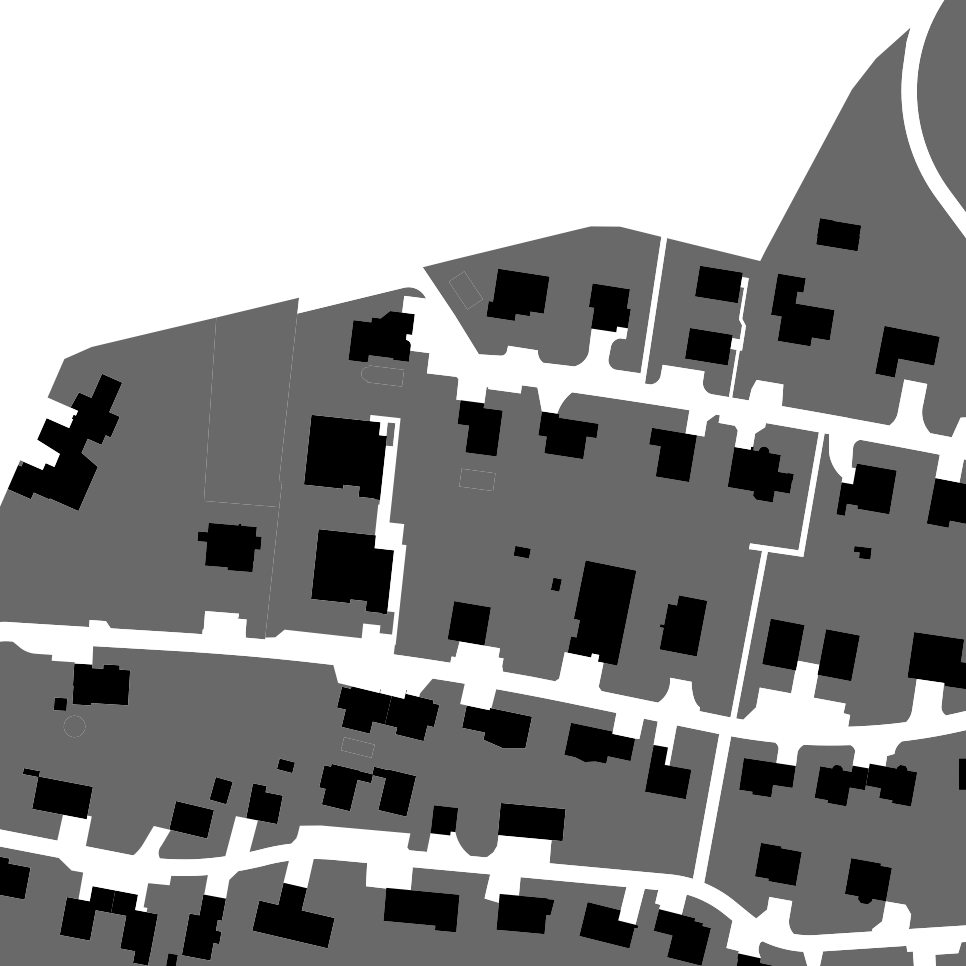

In [30]:
fig, ax = plt.subplots(figsize=(res_multiplier*64/resolution,res_multiplier*64/resolution), dpi=resolution, frameon=False)
# ax = plt.axes([0,0,1,1], frameon=False)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
#plt.autoscale(tight=True)
ax.axis('off')
mpl.rcParams['savefig.pad_inches'] = 0

ax.set_xlim(boxGDF.bounds['minx'].item(), boxGDF.bounds['maxx'].item())
ax.set_ylim(boxGDF.bounds['miny'].item(), boxGDF.bounds['maxy'].item())
res.plot(ax=ax, color=res['col']);